# Кейс-чемпионат для студентов GPN INTELLIGENCE CUP: "Data scientist в управлении проектной командой"

##Описание проекта

С момента учреждения Гильдия Искателей Приключений выполняет многочисленные поручения: герои сражаются с монстрами, исследуют руины, добывают редкие ресурсы, спасают путешественников. Со временем поток заданий стал настолько велик, что герои перестали тщательно выбирать миссии, что привело к неудачам и негативным отзывам от заказчиков. Чтобы улучшить качество выполнения поручений и повысить выручку гильдии, было решено внедрить волшебный древесный компьютер — Аркашу, разработанный Лесной академией. Аркаша будет подбирать оптимальные команды героев для выполнения заданий, опираясь на их прошлый опыт, навыки и роли.

**Целью проекта** является оптимизация выполнения поручений. Надо научить Аркашу подбирать подходящих героев на основе их навыков и истории выполненных заданий. Это позволит эффективно распределять ресурсы героев и повышать процент успешных миссий.

Для сложных задач Аркаша должен уметь формировать команды от одного до четырех героев, где каждый участник вносит свой вклад в успех миссии. Необходимо научить Аркашу предлагать такие команды и сочетания героев, чтобы обеспечивалась максимальная выручка гильдии, оптимизируя одновременно скорость выполнения поручений. Поскольку задания написаны обычными жителями, Аркаша должен уметь понимать синонимичные и неформальные формулировки. Это позволит ему правильно классифицировать поручения и лучше предсказывать, какие герои смогут справиться с миссией лучше. Так же проект предполагает анализ дневников героев и отзывов от клиентов, которые оценивают героев по качеству работы, срокам выполнения и вежливости. На основе этих данных Аркаша сможет учитывать успешные показатели каждого героя и рекомендовать их для новых миссий.

Проект имеет большую **важность** для улучшения эффективности и устойчивости Гильдии Искателей Приключений. Применение рекомендательной системы позволит сократить риск неудачных миссий, повысить удовлетворенность клиентов, а также значительно увеличить выручку. Эффективное распределение героев по поручениям обеспечит оптимальное использование ресурсов гильдии, минимизируя простои и недовольство среди заказчиков.



## Импорт и установка библиотек

In [ ]:
!pip install -q sentence-transformers

In [ ]:
# Стандартные библиотеки
from datetime import datetime, timedelta
import re

# Сторонние библиотеки
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import torch

# Загрузка необходимых данных для NLTK
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Анализ таблицы *cases*






Для начала загружаю и смотрю информацию о таблице

In [ ]:
# загрузка и вывод первых строк
cases = pd.read_csv('cases.csv', delimiter=';')
cases.head()

,﻿Номер поручения,Заказчик,Дата поручения,Выполнено,Дата выполнения,Затрачено дней,Сумма вознаграждения,Описание
0,11000,Анна,1051-08-11,да,1051-08-21,4.0,6000,В лесу по дороге от пещеры звери нападают на л...
1,11001,Мария,1051-07-09,да,1051-09-02,2.0,20000,В лесу по дороге от пещеры были замечены разбо...
2,11002,Эмилио,1053-10-05,да,1053-10-20,7.0,22500,По дороге из деревни монстры похитили путников...
3,11003,Бьянка,1052-11-24,да,1052-12-02,5.0,5500,Недалеко от города видели монстров. Нужно побе...
4,11004,Бьянка,1052-02-23,да,1052-03-30,8.0,10500,В деревне у меня пропала сумка с документами. ...


In [ ]:
# просмотр информации
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ﻿Номер поручения      500 non-null    int64  
 1   Заказчик              500 non-null    object 
 2   Дата поручения        500 non-null    object 
 3   Выполнено             500 non-null    object 
 4   Дата выполнения       481 non-null    object 
 5   Затрачено дней        481 non-null    float64
 6   Сумма вознаграждения  500 non-null    int64  
 7   Описание              500 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.4+ KB


При просмотре количества уникальных номеров поручений была получена ошибка, которая укзывала на возможные лишние символы в названии столбцов. При стандартной обработке был обнаружен невидимый символ, который называется BOM (Byte Order Mark), или маркер порядка байтов.

In [ ]:
# Удаляние лишних символов названии столбцов
cases.columns = cases.columns.str.strip()

cases.columns.tolist()

['\ufeffНомер поручения',
 'Заказчик',
 'Дата поручения',
 'Выполнено',
 'Дата выполнения',
 'Затрачено дней',
 'Сумма вознаграждения',
 'Описание']

In [ ]:
# удаляение BOM и других лишних пробелов
cases.columns = cases.columns.str.replace('\ufeff', '').str.strip()

cases.columns.tolist()

['Номер поручения',
 'Заказчик',
 'Дата поручения',
 'Выполнено',
 'Дата выполнения',
 'Затрачено дней',
 'Сумма вознаграждения',
 'Описание']

In [ ]:
# количество уникальных поручений
cases['Номер поручения'].nunique()


500

Перед обработкой пропусков надо посмотреть, что это за пропуски, возможно понять природу их пояления

In [ ]:
# строки, которые содержат пропуски
missing_rows_before = cases[cases.isnull().any(axis=1)]

missing_rows_before

,Номер поручения,Заказчик,Дата поручения,Выполнено,Дата выполнения,Затрачено дней,Сумма вознаграждения,Описание
56,11056,Мария,1053-09-06,нет,NaN,NaN,23500,По дороге из деревни у меня пропала драгоценно...
134,11134,Иван,1053-09-04,нет,NaN,NaN,27500,В пещере появвилось огромное каменное чудовище...
143,11143,Егор,1053-10-18,нет,NaN,NaN,10500,В пещере завёлся дракон. Нужно его убить. Это ...
161,11161,Эмилио,1053-10-03,нет,NaN,NaN,7500,В городе у меня потерялся рюкзак. Нужно найти ...
218,11218,Олег,1053-10-01,нет,NaN,NaN,16000,Недалеко от города монстры похитили путников. ...
232,11232,Бабушка Синь,1053-10-22,нет,NaN,NaN,17500,В деревне монстры похитили путников. Нужно спа...
234,11234,Олег,1053-10-24,нет,NaN,NaN,17000,В лесу по дороге от пещеры заметили разбойнико...
285,11285,Чарли,1053-09-30,нет,NaN,NaN,5000,В городе у меня потерялся рюкзак. Нужно найти ...
306,11306,Олег,1053-11-15,нет,NaN,NaN,17000,В деревне монстры похитили путников. Нужно спа...
310,11310,Надя,1053-09-24,нет,NaN,NaN,5000,По дороге из деревни монстры похитили путников...


Пропуски находятся в строках, где поручение еще не выполнено. А раз поручение находится в стадии выполнения, то и даты выполнения поручения еще не стоят, соответственно и количество дней, затраченных на поручение стоять не может.
Так как пропуски будут мешать дальнейшей работе с таблицей, а удалять их без понимания полной картины происходящего абсурдно, то решаю заполнить пропуски в столбце 'Дата выполнения' самой "свежей" датой из этого датафрейма. Столбец 'Затрачено дней' будет рассчитан как разница между датой поручения и датой выполнения.   
Так как изначально столбцы с датами стоят в неправильном формате, то для начала работы с ними их нужно перевсти в нужный формат. Во время этого шага возникла ошибка связанная с тем, что pandas не смог обработать такие древние даты. Для обработки были испробованы следующие методы и библиотеки для работы с датами:
- Pandas — был применен метод pd.to_datetime() для конвертации строк в формат даты - не получилось
- re (регулярные выражения) — использованы для предварительной очистки форматов дат, в частности, чтобы извлечь отдельные части даты, если она была записана не в стандартном формате - не получилось
- Datetime — использован метод datetime.strptime() для парсинга нестандартных строк дат в объект datetime - получилось

Код в ячейке добавляет 1000 лет к датам выполнения и поручения в таблице cases, затем рассчитывает количество дней, затраченных на выполнение задачи, и возвращает даты к их исходным значениям.
Функция parse_date_with_offset добавляет 1000 лет к дате, если она находится в строковом формате. Сначала принимает date_str, который может быть строкой (например, '2022-03-15') или значением NaN. Затем если значение является строкой, функция пытается преобразовать её в объект datetime с форматом '%Y-%m-%d'. И если преобразование успешно, функция добавляет 1000 лет к году и возвращает новую дату. Если дата в формате NaN (или если строка не соответствует формату даты), функция возвращает None.

Далее пропущенные значения (NaN) в столбце 'Дата выполнения' заполняются самой поздней датой, найденной в этом столбце. Затем вычисляется разница в днях между 'Дата выполнения' и 'Дата поручения', которая сохраняется в столбце 'Затрачено дней'. И в конце дата снова уменьшается на 1000 лет, чтобы вернуть её к исходному значению



In [ ]:
# преобразование дат и заполнение пропусков
def parse_date_with_offset(date_str):
    if isinstance(date_str, str):
        try:
            parsed_date = datetime.strptime(date_str, '%Y-%m-%d')
            return datetime(parsed_date.year + 1000, parsed_date.month, parsed_date.day)
        except ValueError:
            return None
    elif isinstance(date_str, float) and np.isnan(date_str):
        return None
    else:
        return None

cases['Дата выполнения'] = cases['Дата выполнения'].apply(parse_date_with_offset)
cases['Дата поручения'] = cases['Дата поручения'].apply(parse_date_with_offset)

latest_date = cases['Дата выполнения'].max()
cases['Дата выполнения'] = cases['Дата выполнения'].fillna(latest_date)

cases['Затрачено дней'] = (cases['Дата выполнения'] - cases['Дата поручения']).dt.days

cases['Дата выполнения'] = cases['Дата выполнения'].apply(lambda x: datetime(x.year - 1000, x.month, x.day) if pd.notnull(x) else x)
cases['Дата поручения'] = cases['Дата поручения'].apply(lambda x: datetime(x.year - 1000, x.month, x.day) if pd.notnull(x) else x)

cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Номер поручения       500 non-null    int64 
 1   Заказчик              500 non-null    object
 2   Дата поручения        500 non-null    object
 3   Выполнено             500 non-null    object
 4   Дата выполнения       500 non-null    object
 5   Затрачено дней        500 non-null    int64 
 6   Сумма вознаграждения  500 non-null    int64 
 7   Описание              500 non-null    object
dtypes: int64(3), object(5)
memory usage: 31.4+ KB


Для просмотра результата заполнения, выведу строки с заполненными пропусками. Так как пропусков в таблице больше нет, то выведу строки, в которых в столбце 'Выполнено' указано 'нет' - это и будут те самые поручения

In [ ]:
# результат заполнения
filled_rows = cases[cases['Выполнено'] == 'нет'][['Дата поручения', 'Дата выполнения', 'Затрачено дней']]

filled_rows

,Дата поручения,Дата выполнения,Затрачено дней
56,1053-09-06 00:00:00,1054-01-13 00:00:00,129
134,1053-09-04 00:00:00,1054-01-13 00:00:00,131
143,1053-10-18 00:00:00,1054-01-13 00:00:00,87
161,1053-10-03 00:00:00,1054-01-13 00:00:00,102
218,1053-10-01 00:00:00,1054-01-13 00:00:00,104
232,1053-10-22 00:00:00,1054-01-13 00:00:00,83
234,1053-10-24 00:00:00,1054-01-13 00:00:00,81
285,1053-09-30 00:00:00,1054-01-13 00:00:00,105
306,1053-11-15 00:00:00,1054-01-13 00:00:00,59
310,1053-09-24 00:00:00,1054-01-13 00:00:00,111


На всякий случай проведу дополнительные проверки в заполненных столбцах и проверю наличие дубликатов

In [ ]:
print("Минимальная дата выполнения:", cases['Дата выполнения'].min())
print("Максимальная дата выполнения:", cases['Дата выполнения'].max())


Минимальная дата выполнения: 1051-01-14 00:00:00
Максимальная дата выполнения: 1054-01-13 00:00:00


In [ ]:
print("Отрицательные значения в 'Затрачено дней':", cases[cases['Затрачено дней'] < 0].shape[0])


Отрицательные значения в 'Затрачено дней': 0


In [ ]:
# дубликаты
duplicates = cases.duplicated()
print("Количество дубликатов:", duplicates.sum())


Количество дубликатов: 0


In [ ]:
# просмотр статистик
cases.describe()

,Номер поручения,Затрачено дней,Сумма вознаграждения
count,500.000000,500.000000,500.000000
mean,11249.500000,33.704000,16836.000000
std,144.481833,21.417792,7492.488155
min,11000.000000,3.000000,5000.000000
25%,11124.750000,16.000000,10000.000000
50%,11249.500000,33.000000,16500.000000
75%,11374.250000,49.250000,23500.000000
max,11499.000000,131.000000,29500.000000


*Сумма вознаграждения*
- среднее вознаграждение составляет 16,836. Это примерно в середине диапазона между минимумом и максимумом, что говорит о достаточно сбалансированном распределении
- стандартное отклонение говорит о том, что выплаты могут сильно варьироваться.
- медиана (50%) — 16,500, что очень близко к среднему. Это признак того, что распределение вознаграждений симметрично
- диапазон (от 5,000 до 29,500) показывает, что самые высокие вознаграждения почти в 6 раз выше минимальных

*Затрачено дней*
- среднее время выполнения поручения составляет около 34 дней, с отклонением примерно 21 день. Это довольно большой разброс, что указывает на разное время выполнения поручений
- минимальное время — всего 3 дня, а максимальное — 131 день, что может указывать на поручения разной сложности или удалённости.
- медиана — 33 дня, что также близко к среднему. Это говорит о симметричном распределении времени

*Общие выводы*

В обоих столбцах распределения относительно симметричны, хотя в 'Затрачено дней' есть поручения, которые занимают значительно больше времени (возможно, сложные или долгосрочные задачи).

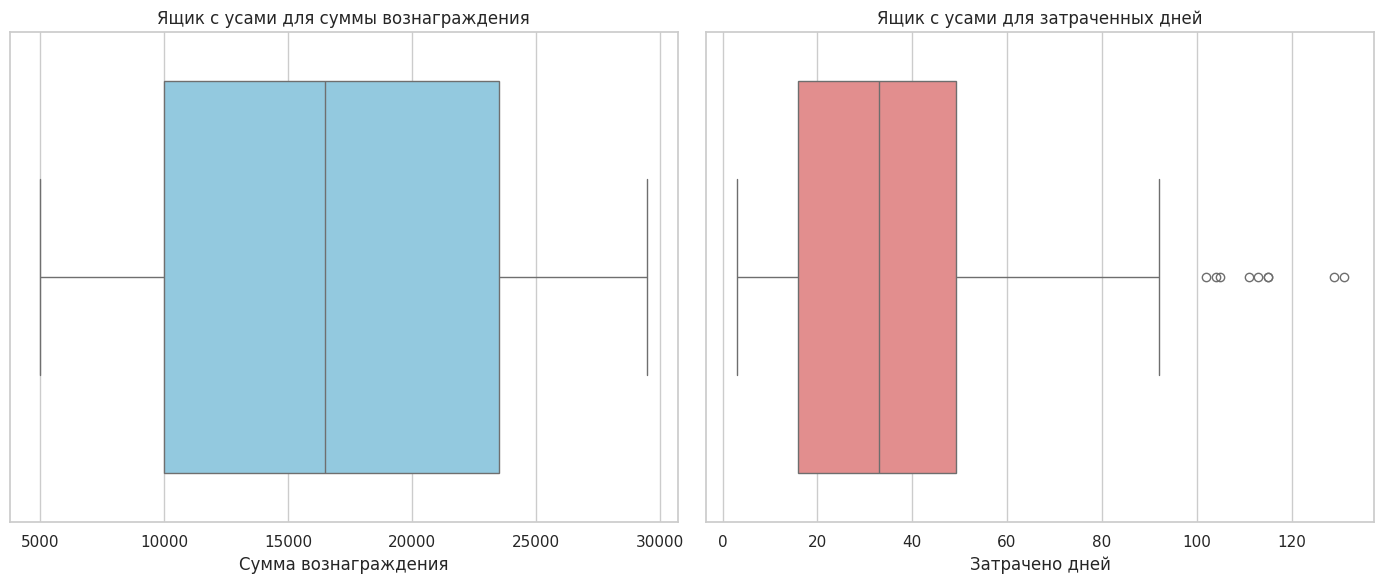

In [ ]:
# просмотр графиков
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=cases['Сумма вознаграждения'], color='skyblue')
plt.title("Ящик с усами для суммы вознаграждения")

plt.subplot(1, 2, 2)
sns.boxplot(x=cases['Затрачено дней'], color='lightcoral')
plt.title("Ящик с усами для затраченных дней")

plt.tight_layout()
plt.show()

На графиках видно, что сумма вознаграждения сбалансирована, тогда как у затраченных дней есть немного отклоняющихся значений. Но если вспомнить, что еще не все задания выполнены, а некоторые возможно имели большую сложность или сильную дальность, то эти отклонения точно не стоит считать выбросами.

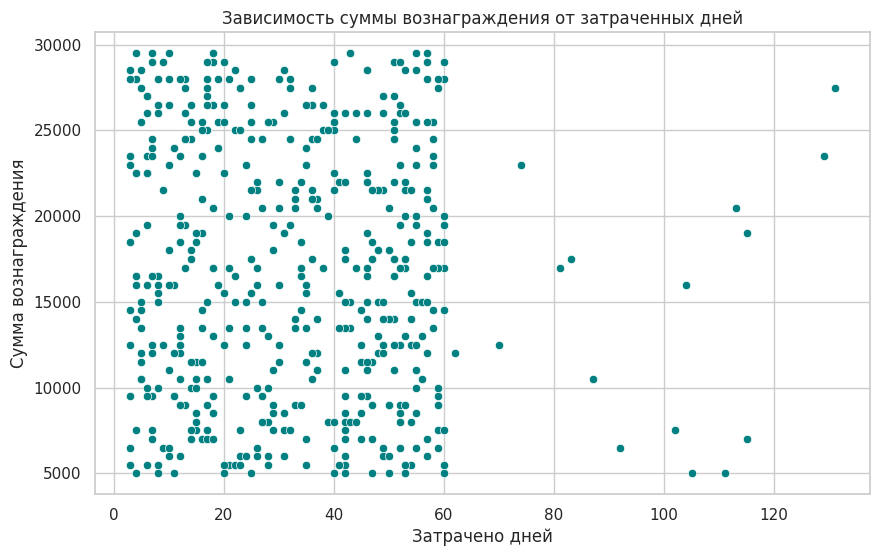

In [ ]:
# просмотр графиков
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.scatterplot(data=cases, x='Затрачено дней', y='Сумма вознаграждения', color='teal')
plt.title("Зависимость суммы вознаграждения от затраченных дней")
plt.xlabel("Затрачено дней")
plt.ylabel("Сумма вознаграждения")
plt.show()

На графике видно, что сумма вознаграждения не зависит от количества затраченных дней. Есть даже немного поручений, когда дней былозатрачено очень много, а вот оплата была минимальная

# Анализ таблицы *diaries*

Загружаю и просмотрариваю первые строчки датафрейма и информации по нему.

In [ ]:
# загрузка и вывод первых строк
diaries = pd.read_csv('diaries.csv', delimiter=';')
diaries.head()

,Номер поручения,Герой,Запись в дневнике,Затрачено часов,Роль
0,11000,Мартин,разжечь костёр,1,рейнджер
1,11000,Мартин,выследить цель,6,следопыт
2,11001,Альфред,разжечь костёр,1,рейнджер
3,11001,Альфред,залечить раны,18,лекарь
4,11002,Мартин,выследить цель,6,следопыт


In [ ]:
# просмотр информации
diaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Номер поручения    888 non-null    int64 
 1   Герой              888 non-null    object
 2   Запись в дневнике  888 non-null    object
 3   Затрачено часов    888 non-null    object
 4   Роль               888 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.8+ KB


In [ ]:
# количество уникальных номеров поручений
diaries['Номер поручения'].nunique()

481

Первое, что бросается в глаза - это несовпадение количества строк с первой таблицей. Чтобы понять причину смотрю количество уникальных номеров поручений и получается, что в этой таблице номеров поручений меньше, чем в таблице cases. Делаю предположение, что в этой таблице не хватает номеров поручений, которые имели пропуск в первой таблице, и которые в итоге имели статус не выполнено. Так как данная таблица содержит информацию о герое и его роли, то предположу, что герой либо еще не назначен, либо информация о нем не заполнена, так как поручение еще не выполнилось.

Проверю первое предположение и проверю каких номеров поручения не хватает в данной таблице. Код ниже фильтрует невыполненные поручения в таблице cases, затем проверяет, какие из них отсутствуют в таблице diaries, и выводит строки о невыполненных поручениях, для которых нет записей в diaries.
Сначала создаётся новая таблица cases_not_done, в которой сохраняются только те строки из cases, где значение в столбце 'Выполнено' равно 'нет'. То есть остаются только невыполненные поручения.
Далее из таблицы cases_not_done извлекаются уникальные номера невыполненных поручений и сохраняются в not_done_ids. Это создаёт список всех уникальных поручений, которые не были выполнены. Таблица diaries группируется по столбцу 'Номер поручения', а затем для каждого номера поручения подсчитывается количество записей (сохранено в колонке Count). В результате создаётся таблица diaries_grouped, где каждая строка — уникальный номер поручения и количество записей для него в diaries.
Потом фильтруются строки из cases_not_done, которые не имеют соответствующих записей в diaries. Тут проверяется, какие номера поручений из cases_not_done отсутствуют в diaries_grouped. В результате создаётся таблица missing_in_diaries, содержащая невыполненные поручения, для которых нет записей в diaries.

In [ ]:
# проверка отсутствующих поручений
cases_not_done = cases[cases['Выполнено'] == 'нет']

not_done_ids = cases_not_done['Номер поручения'].unique()

diaries_grouped = diaries.groupby('Номер поручения').size().reset_index(name='Count')

missing_in_diaries = cases_not_done[~cases_not_done['Номер поручения'].isin(diaries_grouped['Номер поручения'])]

missing_in_diaries[['Номер поручения', 'Заказчик', 'Описание']]

,Номер поручения,Заказчик,Описание
56,11056,Мария,По дороге из деревни у меня пропала драгоценно...
134,11134,Иван,В пещере появвилось огромное каменное чудовище...
143,11143,Егор,В пещере завёлся дракон. Нужно его убить. Это ...
161,11161,Эмилио,В городе у меня потерялся рюкзак. Нужно найти ...
218,11218,Олег,Недалеко от города монстры похитили путников. ...
232,11232,Бабушка Синь,В деревне монстры похитили путников. Нужно спа...
234,11234,Олег,В лесу по дороге от пещеры заметили разбойнико...
285,11285,Чарли,В городе у меня потерялся рюкзак. Нужно найти ...
306,11306,Олег,В деревне монстры похитили путников. Нужно спа...
310,11310,Надя,По дороге из деревни монстры похитили путников...


Проверка подтвердила, что в таблице diaries отсутствуют номера поручений, в которых в таблице cases чтоит статус не выполнено. Значит сведений о герое просто нет или еще не внесли.

In [ ]:
# дубликаты
duplicates = diaries.duplicated()
print("Количество дубликатов:", duplicates.sum())


Количество дубликатов: 0


В столбце 'Затрачено часов' указан не правильный тип данных. Скорее всего это связанно с тем, что в числах вместо точек стоят запятые. Заменю запятые на точки и преобразую в числовой формат.

In [ ]:
# замена и преобразование
diaries['Затрачено часов'] = diaries['Затрачено часов'].str.replace(',', '.').astype(float)
diaries['Затрачено часов'] = diaries['Затрачено часов'].round(1)

diaries.dtypes

,0
Номер поручения,int64
Герой,object
Запись в дневнике,object
Затрачено часов,float64
Роль,object


In [ ]:
# первые строки
diaries.head()

,Номер поручения,Герой,Запись в дневнике,Затрачено часов,Роль
0,11000,Мартин,разжечь костёр,1.0,рейнджер
1,11000,Мартин,выследить цель,6.0,следопыт
2,11001,Альфред,разжечь костёр,1.0,рейнджер
3,11001,Альфред,залечить раны,18.0,лекарь
4,11002,Мартин,выследить цель,6.0,следопыт


Так как при просмотре таблицы видно, что у каждой роли есть разные записи в дневнике, то вывожу на экран для просмотра все роли и соответствующие им записи в дневнике. Для этого прохожусь по каждой уникальной роли из столбца 'Роль' таблицы diaries, собираю уникальные действия для каждой роли из столбца 'Запись в дневнике'. Тут diaries['Роль'].unique() извлекает список всех уникальных значений из столбца 'Роль', а цикл for перебирает каждую роль в этом списке. Для каждой роли выбираются строки в diaries, где значение в столбце 'Роль' совпадает с текущей ролью. Затем с помощью .unique() из столбца 'Запись в дневнике' извлекаются все уникальные действия для этой роли. Результат сохраняется в переменной actions.

In [ ]:
# Группировка по роли и действию
for role in diaries['Роль'].unique():
    actions = diaries[diaries['Роль'] == role]['Запись в дневнике'].unique()
    print(f"Роль: {role}")
    print("Запись в дневнике:", " | ".join(actions))
    print("-" * 50)


Роль: рейнджер
Запись в дневнике: разжечь костёр
--------------------------------------------------
Роль: следопыт
Запись в дневнике: выследить цель | найти пропажу | отыскать заказчика
--------------------------------------------------
Роль: лекарь
Запись в дневнике: залечить раны
--------------------------------------------------
Роль: лучник
Запись в дневнике: разжечь костёр
--------------------------------------------------
Роль: мечник
Запись в дневнике: разжечь костёр
--------------------------------------------------
Роль: боевой маг
Запись в дневнике: разжечь костёр
--------------------------------------------------


Теперь наглядно видны все роли и соответствующие им действия. Можно построить график чтобы посмотреть как эти роли распределены.

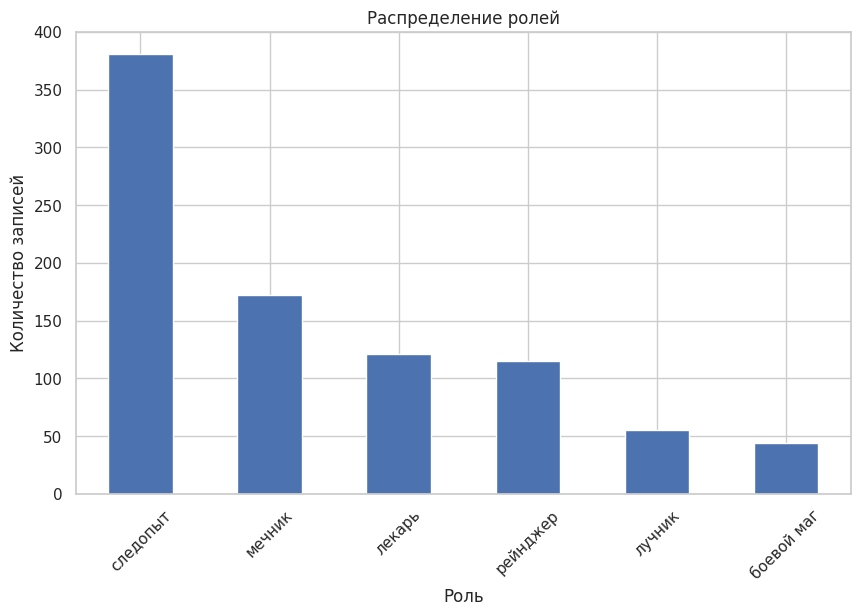

In [ ]:
# график распределение ролей
role_counts = diaries['Роль'].value_counts()
plt.figure(figsize=(10, 6))
role_counts.plot(kind='bar')
plt.title('Распределение ролей')
plt.xlabel('Роль')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()


Из графика видно, что самая популярная роль - следопыт, реже всего встречается лучник и боевой маг.

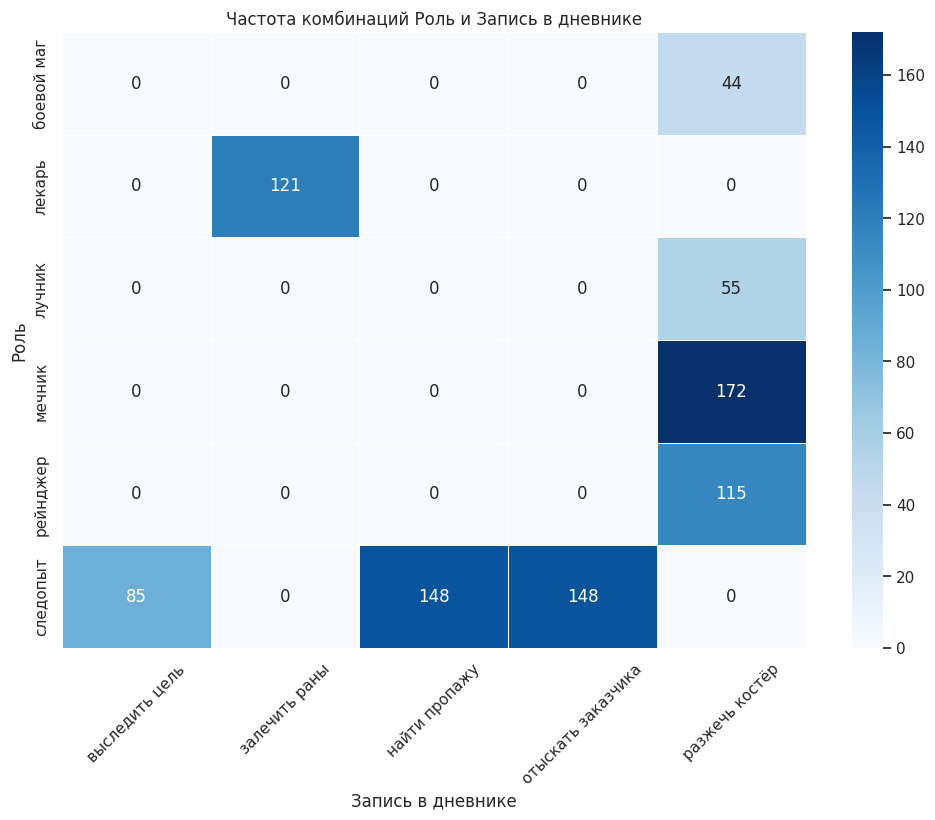

In [ ]:
# тепловая карта
pivot_table = diaries.pivot_table(index='Роль', columns='Запись в дневнике', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Частота комбинаций Роль и Запись в дневнике')
plt.xlabel('Запись в дневнике')
plt.ylabel('Роль')
plt.xticks(rotation=45)
plt.show()


После просмотра тепловой карты стало ясно почему так часто встречается роль следопыта. У следопыта имеется несколько разных действий - записей в дневнике связанных с поиском, тогда как остальные роли могут совершать только по одному действию. Так же видно, что только лекарь может залечить раны, а все остальные только разжигают костер.

Теперь интерессно будет посмотреть какие герои выполняют те или иные действия. Для этого сначала группирую по герою и роли. В grouped_hero_role происходит первая группировка по столбцам 'Герой' и 'Роль'. В каждой группе (определяемой уникальной парой "герой-роль") собираются уникальные действия из столбца 'Запись в дневнике'. Эти действия объединяются в строку, разделённую символом |, с помощью функции lambda x: ' | '.join(x.unique()). Итоговый результат содержит столбцы с именем героя, его ролью и всеми уникальными действиями для этой роли.

Потом идет группировка по герою. В grouped_data данные grouped_hero_role группируются только по имени героя.
В столбце 'Роль' перечисляются все уникальные роли для каждого героя, объединенные в строку и разделенные запятыми.
В столбце 'Запись в дневнике' объединяются все уникальные записи действий героя, разделенные символом |.
Эта агрегированная таблица представляет для каждого героя полный список его ролей и соответствующих действий.


In [ ]:
# уникальные записи по действиям
grouped_hero_role = diaries.groupby(['Герой', 'Роль'])['Запись в дневнике'].apply(lambda x: ' | '.join(x.unique())).reset_index()

grouped_data = grouped_hero_role.groupby('Герой').agg({
    'Роль': lambda x: ', '.join(x.unique()),
    'Запись в дневнике': lambda x: ' | '.join(x)
}).reset_index()

print(grouped_data)


         Герой                                    Роль  \
0        Агата              лучник, рейнджер, следопыт   
1      Альфред      лекарь, мечник, рейнджер, следопыт   
2       Бендер              мечник, рейнджер, следопыт   
3     Бенедикт      лекарь, мечник, рейнджер, следопыт   
4      Глюкоза          боевой маг, рейнджер, следопыт   
5     Леопольд              мечник, рейнджер, следопыт   
6       Мартин      лекарь, лучник, рейнджер, следопыт   
7     Пастушок              мечник, рейнджер, следопыт   
8   Синеглазый      лекарь, мечник, рейнджер, следопыт   
9         Соня  боевой маг, лекарь, рейнджер, следопыт   
10    Фредерик      лекарь, лучник, рейнджер, следопыт   
11        Юлия      лекарь, мечник, рейнджер, следопыт   

                                    Запись в дневнике  
0   разжечь костёр | разжечь костёр | выследить це...  
1   залечить раны | разжечь костёр | разжечь костё...  
2   разжечь костёр | разжечь костёр | выследить це...  
3   залечить раны | р

Теперь можно посмотреть распределение записей по героям, что бы понять кто чаще всего участвует в поручениях.

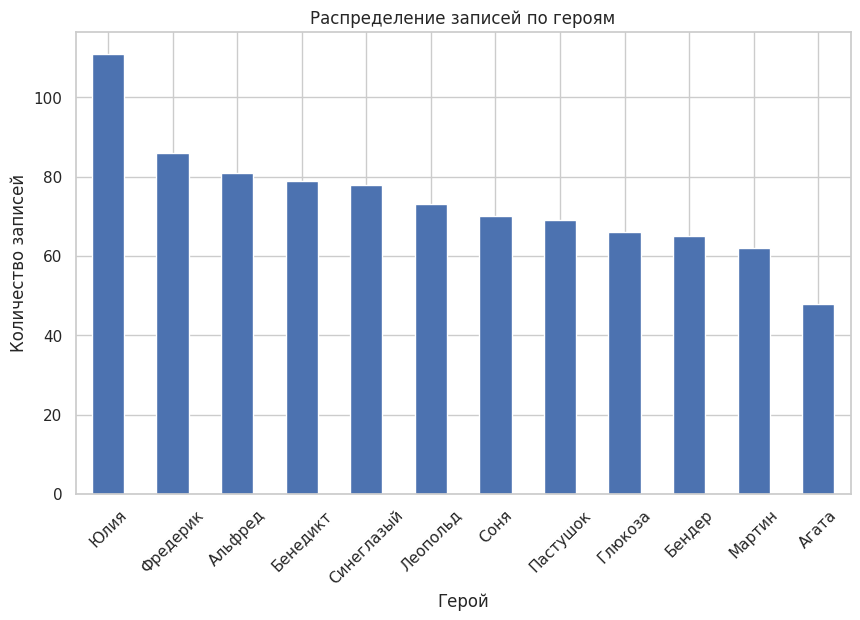

In [ ]:
# распределение записей по героям
hero_counts = diaries['Герой'].value_counts()
plt.figure(figsize=(10, 6))
hero_counts.plot(kind='bar')
plt.title('Распределение записей по героям')
plt.xlabel('Герой')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()


Больше всего поручений выполнила Юлия, меньше всех - Агата. У остальных героев примерно от 61 до 85 поручений было.

Посмотрю теперь как распределены часы в зависимости от роли и записи в дневнике. Для этого пишу код, который выполняет группировку данных из таблицы по двум столбцам - 'Роль' и 'Запись в дневнике', а затем собирает все значения из столбца 'Затрачено часов' для каждой уникальной комбинации роли и действия.

In [ ]:
# распределение часов
role_action_hours = diaries.groupby(['Роль', 'Запись в дневнике'])['Затрачено часов'].agg(list).reset_index()

print(role_action_hours)


         Роль   Запись в дневнике  \
0  боевой маг      разжечь костёр   
1      лекарь       залечить раны   
2      лучник      разжечь костёр   
3      мечник      разжечь костёр   
4    рейнджер      разжечь костёр   
5    следопыт      выследить цель   
6    следопыт       найти пропажу   
7    следопыт  отыскать заказчика   

                                     Затрачено часов  
0  [0.7, 0.7, 1.0, 1.0, 1.0, 0.7, 0.7, 1.0, 0.7, ...  
1  [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
2  [1.0, 0.7, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 1.0, ...  
3  [2.0, 0.7, 2.0, 0.7, 2.0, 0.7, 0.7, 0.7, 1.0, ...  
4  [1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.7, 2.0, 1.0, ...  
5  [6.0, 6.0, 6.0, 12.0, 12.0, 4.0, 12.0, 6.0, 6....  
6  [4.5, 9.0, 4.5, 4.5, 4.5, 4.5, 9.0, 4.5, 4.5, ...  
7  [3.0, 6.0, 3.0, 3.0, 3.0, 3.0, 6.0, 3.0, 3.0, ...  


Видно, что на одну и ту же роль и действие приходятся разные значения часов. То есть разные герои выполняют однои тоже действие за разное время. Проверю это, для этого пишу  код, который группирует данные в таблице по трём столбцам - 'Роль', 'Запись в дневнике' и 'Герой', а затем собирает все значения из столбца 'Затрачено часов' для каждой уникальной комбинации "роль-действие-герой"

In [ ]:
# группировка по 'Роль', 'Запись в дневнике' и 'Герой'
role_action_hero_hours = diaries.groupby(['Роль', 'Запись в дневнике', 'Герой'])['Затрачено часов'].agg(list).reset_index()

# Печатаем результат
print(role_action_hero_hours.head)

<bound method NDFrame.head of           Роль   Запись в дневнике       Герой  \
0   боевой маг      разжечь костёр     Глюкоза   
1   боевой маг      разжечь костёр        Соня   
2       лекарь       залечить раны     Альфред   
3       лекарь       залечить раны    Бенедикт   
4       лекарь       залечить раны      Мартин   
..         ...                 ...         ...   
62    следопыт  отыскать заказчика    Пастушок   
63    следопыт  отыскать заказчика  Синеглазый   
64    следопыт  отыскать заказчика        Соня   
65    следопыт  отыскать заказчика    Фредерик   
66    следопыт  отыскать заказчика        Юлия   

                                      Затрачено часов  
0   [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, ...  
1   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
2   [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18....  
3   [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...  
4    [18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]  
..                               

Предположение подтвердилось. Теперь посмотрю, как распределены часы - как быстро герои справляются с поручением.

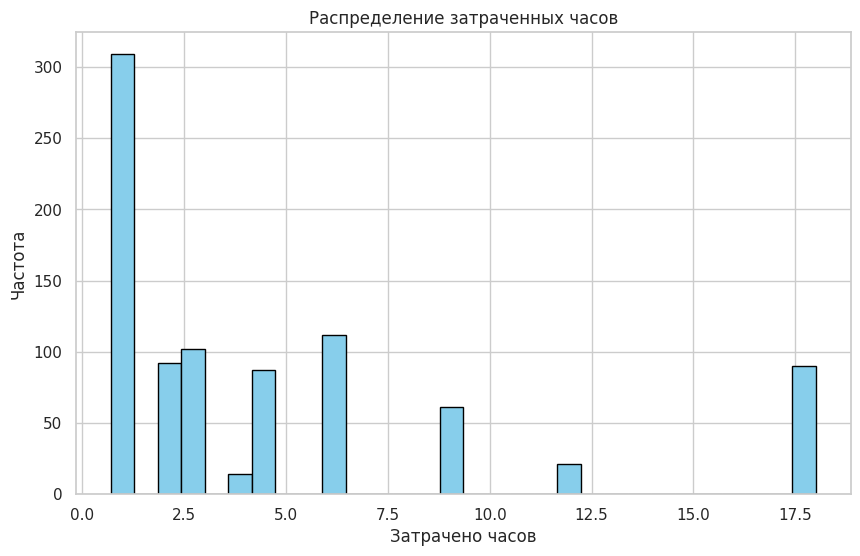

In [ ]:
# гистограмма распределения часов
plt.figure(figsize=(10, 6))
plt.hist(diaries['Затрачено часов'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение затраченных часов')
plt.xlabel('Затрачено часов')
plt.ylabel('Частота')
plt.show()

Чаще всего герои справляются с заданиями примерно за час, но иногда встречаются и очень долгие по времени задания.

Так как количество строк в таблице и количество уникальных поручений не совпадают, посмотрю как распределены записи по каждому номеру поручения.

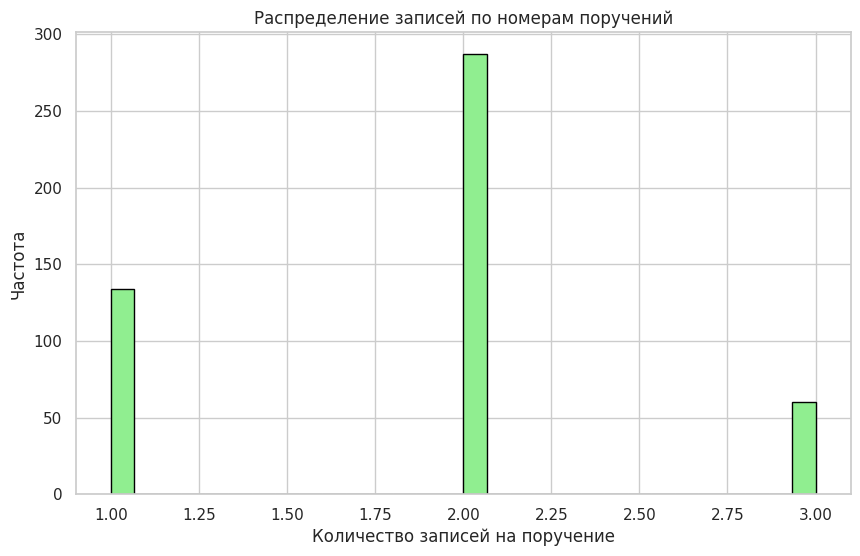

In [ ]:
# количество записей по номеру поручения
task_entries = diaries['Номер поручения'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(task_entries, bins=30, color='lightgreen', edgecolor='black')
plt.title('Распределение записей по номерам поручений')
plt.xlabel('Количество записей на поручение')
plt.ylabel('Частота')
plt.show()


Чаще встречаются записи, где на один номер поручения приходятся две записи, это говорит о том, что герой в рамках одного поручения выполнял две роли. Так же иногда встречались герои, которые выполняли стразу три роли на одно поручение, но таких героев меньше всего.

# Анализ таблицы marks

Загружаю таблицу и просматриваю информацию о ней, так же проверяю дубликаты.

In [ ]:
# загрузка и вывод первых строк
marks = pd.read_csv('marks.csv', delimiter=';')
marks.head()

,Номер поручения,Герой,Оценка за качество,Оценка по срокам,Оценка за вежливость
0,11000,Мартин,4,3,4
1,11001,Альфред,5,5,4
2,11002,Мартин,5,4,4
3,11003,Бендер,2,4,3
4,11004,Юлия,4,4,5


In [ ]:
# просмотр информации
marks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Номер поручения       500 non-null    int64 
 1   Герой                 500 non-null    object
 2   Оценка за качество    500 non-null    int64 
 3   Оценка по срокам      500 non-null    int64 
 4   Оценка за вежливость  500 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 19.7+ KB


In [ ]:
# дубликаты
duplicates = marks.duplicated()
print("Количество дубликатов:", duplicates.sum())

Количество дубликатов: 0


In [ ]:
# количество уникальных номеров поручений
marks['Номер поручения'].nunique()

500

Так как количество уникальных поручений больше чем в предыдущей таблице с героями, но столько же сколько в первой с описанием заданий, то считаю нужным проверить, совпадают ли номера поручений, которые отсутствовали в таблице diaries с теми поручениями, которые были в cases. Для этого я использую список поручений, который я уже выводила в таблице daries и отфильтрую новую таблицу этим списком.

In [ ]:
# проверка пропущенных поручений, найденных ранее
missing_order_numbers = not_done_ids

missing_marks = marks[marks['Номер поручения'].isin(missing_order_numbers)]

print(missing_marks)


     Номер поручения       Герой  Оценка за качество  Оценка по срокам  \
56             11056  Синеглазый                   4                 4   
134            11134    Пастушок                   5                 4   
143            11143        Юлия                   5                 4   
161            11161       Агата                   4                 4   
218            11218       Агата                   4                 3   
232            11232        Юлия                   3                 5   
234            11234    Пастушок                   4                 4   
285            11285     Альфред                   4                 3   
306            11306        Юлия                   3                 5   
310            11310    Бенедикт                   4                 3   
311            11311       Агата                   4                 5   
381            11381  Синеглазый                   5                 4   
387            11387    Пастушок      

Проверка показала, что в данной таблице содержатся номера поручений, которые отсутствовали в предыдущей таблице, но при этом эти номера были в таблице cases, это значит что пропущенных данных не так много и есть шанс их восстановить.

Так как эта таблица содержит оценки за выполненные поручения, то считаю нужным посмотреть распределение этих оценок .

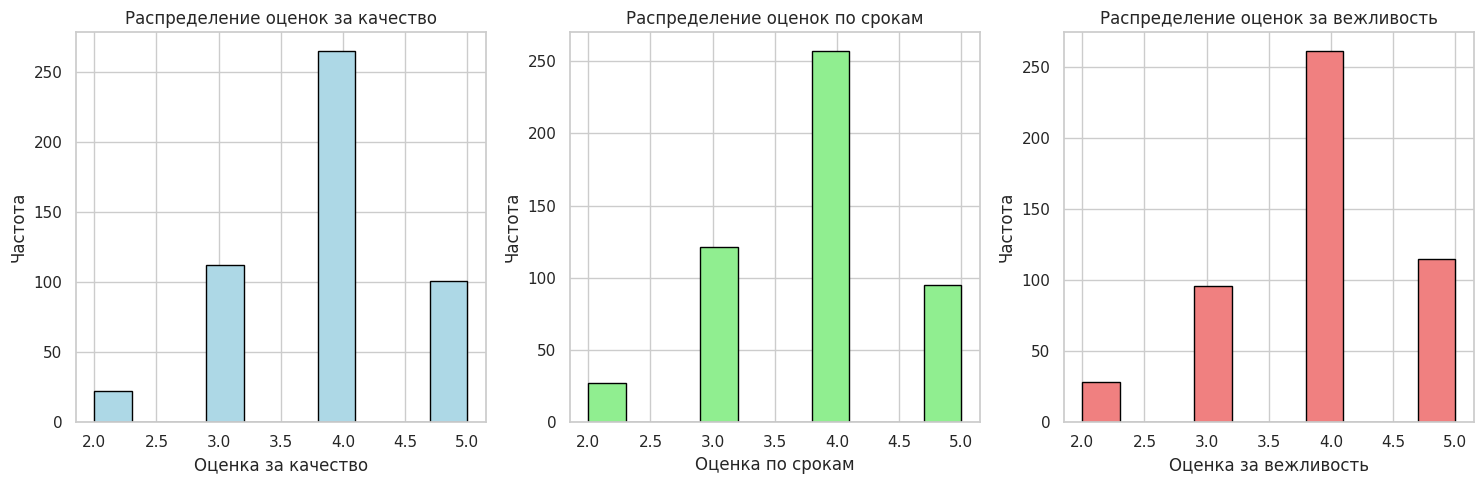

In [ ]:
# распределение оценок
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(marks['Оценка за качество'], bins=10, color='lightblue', edgecolor='black')
axes[0].set_title('Распределение оценок за качество')
axes[0].set_xlabel('Оценка за качество')
axes[0].set_ylabel('Частота')

axes[1].hist(marks['Оценка по срокам'], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title('Распределение оценок по срокам')
axes[1].set_xlabel('Оценка по срокам')
axes[1].set_ylabel('Частота')

axes[2].hist(marks['Оценка за вежливость'], bins=10, color='lightcoral', edgecolor='black')
axes[2].set_title('Распределение оценок за вежливость')
axes[2].set_xlabel('Оценка за вежливость')
axes[2].set_ylabel('Частота')

plt.tight_layout()
plt.show()


Чаще героям выставляют оценку 4 - это касается качества, сроков и вежливости.

За качество так же чаще ставят 3, чем 5, а так же иногда встречается 2 - это говорит о том, что герои справляются со своими поручениями не идеально.

По срокам распределение идентично качеству, значит и сроком выполнения заказчики тоже не довольны.

С вежливостью у героев дела обстоят лучше, чаще всего им ставят 4, на втором месте 5. Хотя есть герои, которым поставили 2, но их мало


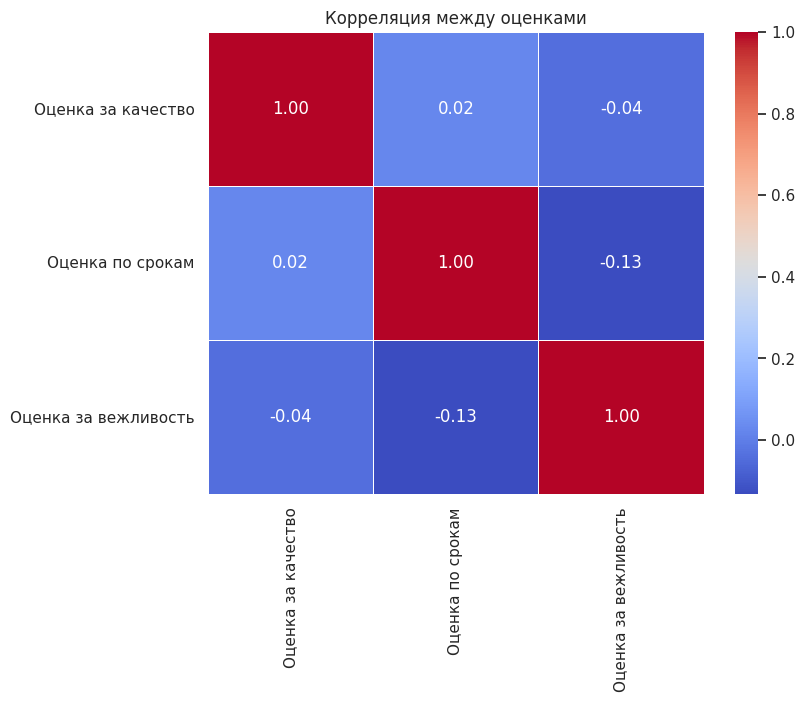

In [ ]:
# корреляция между оценками
correlation_matrix = marks[['Оценка за качество', 'Оценка по срокам', 'Оценка за вежливость']].corr()

# тепловая карта
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между оценками')
plt.show()


Между оценками корреляция отсутствует, значит нет никакой взаимосвязи с тем, что если герой не вежливый, то и за качество ему поставят низкую оценку. Судя по всему, заказчики оценивают героев честно.

Теперь посмотрю как распределялись средние оценки по каждому герою.

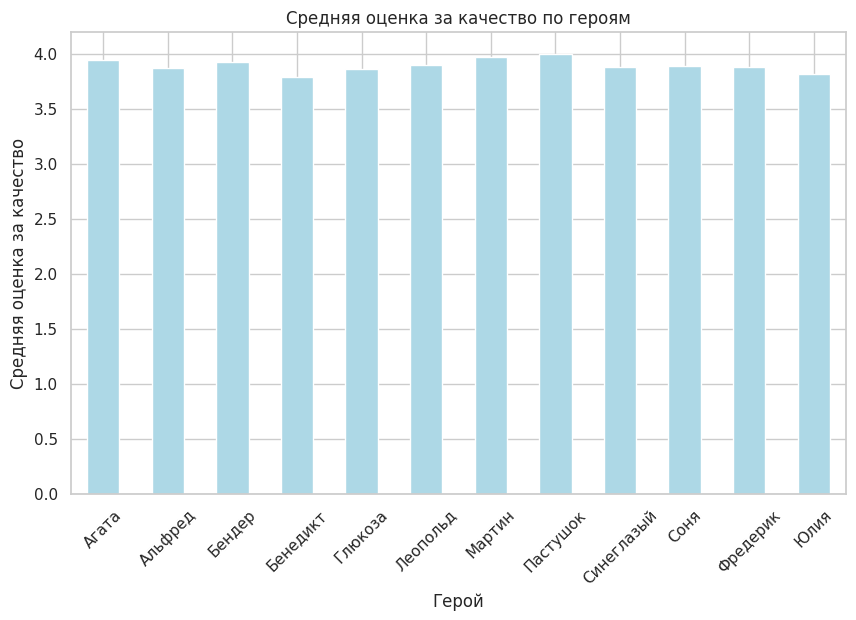

In [ ]:
# столбчатая диаграмма для средней оценки за качество
hero_avg_scores = marks.groupby('Герой').mean()

plt.figure(figsize=(10, 6))
hero_avg_scores['Оценка за качество'].plot(kind='bar', color='lightblue')
plt.title('Средняя оценка за качество по героям')
plt.xlabel('Герой')
plt.ylabel('Средняя оценка за качество')
plt.xticks(rotation=45)
plt.show()


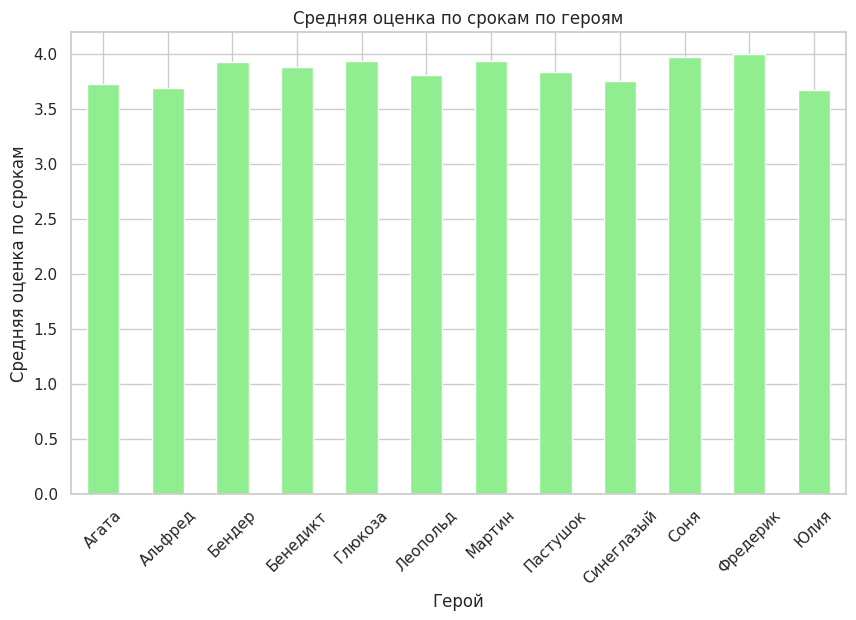

In [ ]:
# столбчатая диаграмма для средней оценки по срокам
plt.figure(figsize=(10, 6))
hero_avg_scores['Оценка по срокам'].plot(kind='bar', color='lightgreen')
plt.title('Средняя оценка по срокам по героям')
plt.xlabel('Герой')
plt.ylabel('Средняя оценка по срокам')
plt.xticks(rotation=45)
plt.show()


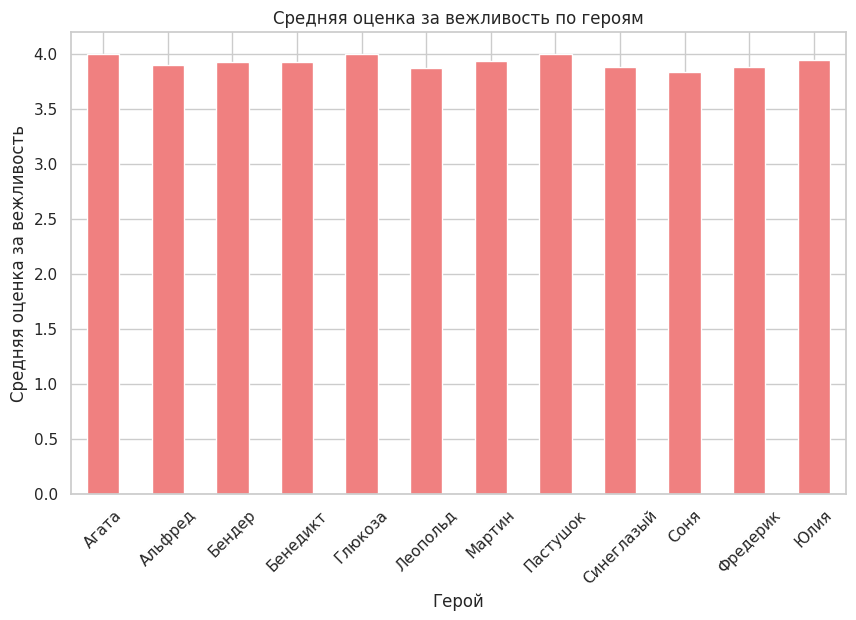

In [ ]:
# столбчатая диаграмма для средней оценки за вежливость
plt.figure(figsize=(10, 6))
hero_avg_scores['Оценка за вежливость'].plot(kind='bar', color='lightcoral')
plt.title('Средняя оценка за вежливость по героям')
plt.xlabel('Герой')
plt.ylabel('Средняя оценка за вежливость')
plt.xticks(rotation=45)
plt.show()


Судя по графикам, средние оценки героев за качество, скорость и вежливость не такие плохие - у всех примерно средняя оценка в районе 4. Есть, конечно, герои, у которых оценка чуть ближе к 3.5, но при округлении все равно бы получилась 4, так что результат тоже хороший.

# Объединение таблиц

Для дальнейше работы по созданию рекомендательной системы требуется объединить все три датасета. Я специально сначала объединяю таблицы с полным набором номеров поручений. Так как при присоединении таблицы diaries появятся пропуски, а мне визуально проще их видеть не в середине таблицы.

Сначала таблицы cases и marks объединяются по столбцу 'Номер поручения'.
Параметр how='left' делает левое объединение (left join), что означает - в итоговую таблицу merged_cases_marks попадут все строки из cases, даже если для некоторых поручений не найдется соответствующих оценок в marks. Если оценок нет, значения будут заполнены NaN.
Далее объединяется таблица merged_cases_marks с таблицей diaries также по столбцу 'Номер поручения'. Используется how='left', чтобы в итоговой таблице merged_data сохранились все строки из merged_cases_marks. Строки без соответствующих записей в diaries будут заполнены значениями NaN.

В результате итоговая таблица merged_data содержит всю информацию из cases, включая, если есть, соответствующие оценки из marks и записи в дневнике из diaries для каждого поручения.



In [ ]:
# объединение таблиц
merged_cases_marks = pd.merge(cases, marks, on='Номер поручения', how='left')

merged_data = pd.merge(merged_cases_marks, diaries, on='Номер поручения', how='left')

merged_data.head()

,Номер поручения,Заказчик,Дата поручения,Выполнено,Дата выполнения,Затрачено дней,Сумма вознаграждения,Описание,Герой_x,Оценка за качество,Оценка по срокам,Оценка за вежливость,Герой_y,Запись в дневнике,Затрачено часов,Роль
0,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,Мартин,4,3,4,Мартин,разжечь костёр,1.0,рейнджер
1,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,Мартин,4,3,4,Мартин,выследить цель,6.0,следопыт
2,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,Мартин,4,3,4,Мартин,разжечь костёр,1.0,лучник
3,11001,Мария,1051-07-09 00:00:00,да,1051-09-02 00:00:00,55,20000,В лесу по дороге от пещеры были замечены разбо...,Альфред,5,5,4,Альфред,разжечь костёр,1.0,рейнджер
4,11001,Мария,1051-07-09 00:00:00,да,1051-09-02 00:00:00,55,20000,В лесу по дороге от пещеры были замечены разбо...,Альфред,5,5,4,Альфред,залечить раны,18.0,лекарь


In [ ]:
# просмотр информации
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Номер поручения       907 non-null    int64  
 1   Заказчик              907 non-null    object 
 2   Дата поручения        907 non-null    object 
 3   Выполнено             907 non-null    object 
 4   Дата выполнения       907 non-null    object 
 5   Затрачено дней        907 non-null    int64  
 6   Сумма вознаграждения  907 non-null    int64  
 7   Описание              907 non-null    object 
 8   Герой_x               907 non-null    object 
 9   Оценка за качество    907 non-null    int64  
 10  Оценка по срокам      907 non-null    int64  
 11  Оценка за вежливость  907 non-null    int64  
 12  Герой_y               888 non-null    object 
 13  Запись в дневнике     888 non-null    object 
 14  Затрачено часов       888 non-null    float64
 15  Роль                  8

In [ ]:
# Проверка на наличие дубликатов
duplicates = merged_data.duplicated()
print("Количество дубликатов:", duplicates.sum())

Количество дубликатов: 0


После просмотра информации стало видно, что столбцы с героями задвоились и один из них имеет пропуски. Предположу, что пропуски связаны с теми самыми отсутствующими поручениями и проверю это.

Для начала проверю, где значения в 'Герой_x' и 'Герой_y' отличаются

In [ ]:
# Проверяем, где значения в 'Герой_x' и 'Герой_y' отличаются
different_heroes = merged_data[merged_data['Герой_x'] != merged_data['Герой_y']]

# Печатаем строки, где 'Герой_x' и 'Герой_y' не совпадают
print(different_heroes[['Номер поручения', 'Герой_x', 'Герой_y']])

     Номер поручения     Герой_x Герой_y
105            11056  Синеглазый     NaN
243            11134    Пастушок     NaN
260            11143        Юлия     NaN
292            11161       Агата     NaN
406            11218       Агата     NaN
432            11232        Юлия     NaN
435            11234    Пастушок     NaN
528            11285     Альфред     NaN
561            11306        Юлия     NaN
567            11310    Бенедикт     NaN
568            11311       Агата     NaN
694            11381  Синеглазый     NaN
705            11387    Пастушок     NaN
717            11396    Бенедикт     NaN
727            11402  Синеглазый     NaN
752            11417    Пастушок     NaN
773            11428        Соня     NaN
793            11438    Леопольд     NaN
833            11462    Леопольд     NaN


Теперь проверю, идентичны ли два набора номеров поручений на основе условий, связанных с колонками Герой_x и Герой_y в таблице.

Сначала из таблицы merged_data извлекаются номера поручений, для которых в колонке 'Герой_y' есть пропуски (NaN).
Выбранные номера поручений добавляются в множество missing_task_numbers (это позволяет избежать дубликатов и эффективно работать с уникальными значениями).

Далее из таблицы different_heroes извлекаются номера поручений, где значения в колонках 'Герой_x' и 'Герой_y' не совпадают.
Эти номера поручений также собираются в виде множества different_heroes_task_numbers. Проверяется, совпадают ли оба множества, т.е., содержат ли они одинаковые номера поручений.

Переменная are_lists_identical примет значение True, если оба множества идентичны, и False — если нет.


In [ ]:
# идентичность списков
missing_task_numbers = set(merged_data[merged_data['Герой_y'].isna()]['Номер поручения'])

different_heroes_task_numbers = set(different_heroes['Номер поручения'])

are_lists_identical = missing_task_numbers == different_heroes_task_numbers
print("Списки идентичны?", are_lists_identical)

Списки идентичны? True


Так как списки идентичны, то заполняю пропуски. Для этого создается столбец 'Герой', который объединяет данные из 'Герой_x' и 'Герой_y', а исходные столбцы удаляются для упрощения структуры таблицы.

Сначала создается новый столбец 'Герой', в который копируются значения из столбца 'Герой_y'.
Если в столбце 'Герой_y' есть пропуски (NaN), они заполняются значениями из столбца 'Герой_x'.
В итоге столбец 'Герой' содержит либо значения из 'Герой_y' (если они существуют), либо из 'Герой_x' (если в 'Герой_y' были пропуски).

Далее удаляются столбцы 'Герой_x' и 'Герой_y', поскольку теперь их значения объединены в новом столбце 'Герой'.


In [ ]:
# создание нового столбца 'Герой'
merged_data['Герой'] = merged_data['Герой_y'].fillna(merged_data['Герой_x'])

merged_data.drop(columns=['Герой_x', 'Герой_y'], inplace=True)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Номер поручения       907 non-null    int64  
 1   Заказчик              907 non-null    object 
 2   Дата поручения        907 non-null    object 
 3   Выполнено             907 non-null    object 
 4   Дата выполнения       907 non-null    object 
 5   Затрачено дней        907 non-null    int64  
 6   Сумма вознаграждения  907 non-null    int64  
 7   Описание              907 non-null    object 
 8   Оценка за качество    907 non-null    int64  
 9   Оценка по срокам      907 non-null    int64  
 10  Оценка за вежливость  907 non-null    int64  
 11  Запись в дневнике     888 non-null    object 
 12  Затрачено часов       888 non-null    float64
 13  Роль                  888 non-null    object 
 14  Герой                 907 non-null    object 
dtypes: float64(1), int64(6)

Теперь надо разобраться с остальными пропусками. Начну со столбцов 'Роль' и 'Запись в дневнике'. Так как заполнение этих столбцов будет зависеть от столбца 'Описание', а это стобец с текстом, то для начала текст надо обработать.

Для начала импортируются русские стоп-слова, которые не несут значимой информации для анализа текста. Далее создается функция preprocess_text, которая выполняет очистку и нормализацию текста - приводит текст к нижнему регистру, чтобы не было различий между заглавными и строчными буквами; удаляет все символы, которые не являются русскими буквами или пробелами; убирает лишние пробелы и приводит текст к чистому, унифицированному виду.

Далее к каждому значению столбца "Описание" в таблице merged_data применяется функция preprocess_text, и результат сохраняется в новый столбец "Описание_clean". Инициализируется TF-IDF векторизатор TfidfVectorizer с учетом русских стоп-слов. Векторизатор применяется к очищенному столбцу "Описание_clean", и создается матрица X_desc, в которой каждый текст описания представлен в виде числовых векторов TF-IDF.

В итоге код очищает и нормализует текст из столбца "Описание", удаляет из него стоп-слова, а затем преобразует очищенные описания в векторы.

In [ ]:
# очистка и нормализация
russian_stopwords = stopwords.words("russian")

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

merged_data['Описание_clean'] = merged_data['Описание'].apply(preprocess_text)

vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
X_desc = vectorizer.fit_transform(merged_data['Описание_clean'].dropna())

merged_data['Описание_clean'].head()

,Описание_clean
0,в лесу по дороге от пещеры звери нападают на л...
1,в лесу по дороге от пещеры звери нападают на л...
2,в лесу по дороге от пещеры звери нападают на л...
3,в лесу по дороге от пещеры были замечены разбо...
4,в лесу по дороге от пещеры были замечены разбо...


Теперь можно обработать пропуски в столюцах 'Роль' и 'Запись в дневнике'.

Загружается модель SentenceTransformer, которая используется для создания эмбеддингов текстов (в данном случае — описаний задач). Создается функция fill_missing_entries, которая:
- принимает строку row (с пропусками в 'Роль' и/или 'Запись в дневнике'), таблицу с существующими данными existing_data, порог сходства threshold, и максимальное количество попыток поиска max_attempts
- находит описание задачи в строке row, ищет похожие записи в existing_data и пытается заполнить пропуски, если находит подходящие роли и действия

Далее создаются эмбеддинги описания задачи из строки row и всех описаний в existing_data и вычисляется косинусное сходство между эмбеддингами текущего описания и всех имеющихся.
На основе значений сходства сортируются индексы от наиболее к наименее похожим задачам.

Потом идет поиск подходящих ролей и действий.
Начинается цикл, в котором max_attempts раз проверяются наиболее похожие записи.
Если текущая запись имеет значение сходства ниже порога threshold, цикл прерывается. Далее проверяется, выполнял ли уже герой из строки row найденную роль. Если герой выполнял эту роль, строка заполняется найденной ролью и записью в дневнике.
Если роль не подходит, переходят к следующему по совпадению описанию.

Потом происходит возвращение результата.
Если подходящая роль найдена, она добавляется в row. Если нет, строка возвращается без изменений. Из таблицы merged_data выбираются строки, где есть пропуски в 'Роль' и/или 'Запись в дневнике', и сохраняются в merged_data_with_na.

В existing_data сохраняются строки без пропусков в этих столбцах. Функция fill_missing_entries применяется ко всем строкам с пропусками, и результат сохраняется в filled_data.
Затем данные из filled_data объединяются с merged_data, чтобы обновить пропуски.

На данном этапе пробовались разные вырианты заполнения. Например, groupby для анализа данных по столбцу 'Герой' и добавление наиболее часто встречающихся значений роли и записей в дневнике для каждого героя. Так же проводился анализ текста и семантический анализ для поиска подсказок, например, использование ключевых слов и фраз, связанных с действиями или типичными обязанностями героев. Но данные заполнялись не корректно и не логично, если смотреть на описание задачи.

In [ ]:
# заполнение пропусков
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

def fill_missing_entries(row, existing_data, threshold=0.70, max_attempts=3):
    description = row['Описание_clean']
    hero = row['Герой']

    existing_descriptions = existing_data['Описание_clean'].tolist()
    embeddings1 = model.encode(description, convert_to_tensor=True)
    embeddings2 = model.encode(existing_descriptions, convert_to_tensor=True)
    cosine_scores = util.cos_sim(embeddings1, embeddings2)

    attempts = 0
    best_match_indices = cosine_scores.argsort(descending=True).squeeze().tolist()

    while attempts < max_attempts and best_match_indices:
        best_match_idx = best_match_indices.pop(0)
        best_match_score = cosine_scores[0, best_match_idx].item()

        if best_match_score < threshold:
            break

        best_match_row = existing_data.iloc[best_match_idx]

        print(f"Описание для {hero}: {description}")
        print(f"Попытка {attempts+1}: совпадение с оценкой {best_match_score}: {best_match_row['Описание_clean']}")
        print(f"Найденная роль: {best_match_row['Роль']}")
        print(f"Уже выполнял роли: {existing_data[existing_data['Герой'] == hero]['Роль'].unique()}")

        hero_roles = existing_data[existing_data['Герой'] == hero]['Роль'].unique()
        if best_match_row['Роль'] in hero_roles:
            print(f"Заполнение для {hero} ролью: {best_match_row['Роль']} и записью в дневнике: {best_match_row['Запись в дневнике']}")
            row['Роль'] = best_match_row['Роль']
            row['Запись в дневнике'] = best_match_row['Запись в дневнике']
            return row
        else:
            print(f"Роль {best_match_row['Роль']} не подходит для героя {hero}, ищем альтернативу...")

        attempts += 1

    print(f"Не удалось найти подходящую роль для героя {hero}, пропускаем.")
    return row

merged_data_with_na = merged_data[merged_data['Роль'].isna() | merged_data['Запись в дневнике'].isna()]
existing_data = merged_data.dropna(subset=['Роль', 'Запись в дневнике'])

filled_data = merged_data_with_na.apply(lambda row: fill_missing_entries(row, existing_data), axis=1)

merged_data.update(filled_data)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Описание для Синеглазый: по дороге из деревни у меня пропала драгоценность нужно вернуть её как можно скорее
Попытка 1: совпадение с оценкой 1.0: по дороге из деревни у меня пропала драгоценность нужно вернуть её как можно скорее
Найденная роль: следопыт
Уже выполнял роли: ['следопыт' 'рейнджер' 'лекарь' 'мечник']
Заполнение для Синеглазый ролью: следопыт и записью в дневнике: отыскать заказчика
Описание для Пастушок: в пещере появвилось огромное каменное чудовище нужно уничтожить его
Попытка 1: совпадение с оценкой 1.0: в пещере появвилось огромное каменное чудовище нужно уничтожить его
Найденная роль: лекарь
Уже выполнял роли: ['мечник' 'рейнджер' 'следопыт']
Роль лекарь не подходит для героя Пастушок, ищем альтернативу...
Описание для Пастушок: в пещере появвилось огромное каменное чудовище нужно уничтожить его
Попытка 2: совпадение с оценкой 1.0: в пещере появвилось огромное каменное чудовище нужно уничтожить его
Найденная роль: мечник
Уже выполнял роли: ['мечник' 'рейнджер' 'следо

Чтобы визуально оценить насколько адекватно прошло заполнение пропусков, фильтрую строки, где есть пропуски в 'Затрачено часов' и вывожу столбцы для проверки

In [ ]:
# фильтрую строки, где есть пропуски в 'Затрачено часов'
filtered_rows = merged_data[merged_data['Затрачено часов'].isna()][['Описание', 'Герой', 'Роль', 'Запись в дневнике', 'Затрачено часов']]

print("Строки с пропусками в 'Затрачено часов' после заполнения 'Роль' и 'Запись в дневнике':")
print(filtered_rows)

Строки с пропусками в 'Затрачено часов' после заполнения 'Роль' и 'Запись в дневнике':
                                              Описание       Герой      Роль  \
105  По дороге из деревни у меня пропала драгоценно...  Синеглазый  следопыт   
243  В пещере появвилось огромное каменное чудовище...    Пастушок    мечник   
260  В пещере завёлся дракон. Нужно его убить. Это ...        Юлия    мечник   
292  В городе у меня потерялся рюкзак. Нужно найти ...       Агата  следопыт   
406  Недалеко от города монстры похитили путников. ...       Агата  следопыт   
432  В деревне монстры похитили путников. Нужно спа...        Юлия  следопыт   
435  В лесу по дороге от пещеры заметили разбойнико...    Пастушок  рейнджер   
528  В городе у меня потерялся рюкзак. Нужно найти ...     Альфред  следопыт   
561  В деревне монстры похитили путников. Нужно спа...        Юлия  следопыт   
567  По дороге из деревни монстры похитили путников...    Бенедикт  следопыт   
568  По дороге из деревни у меня 

Визуально пропуски заполнились корректно, роли и запись в дневнике логично соотносятся с описанием поручения.

Теперь надо заполнить пропуски в столбце 'Затрачено часов', так как каждый герой выполнял одно и то е поручение в одной и той же роли за разное время, то при заполнении надо обязательно учесть этот факт, что бы данные были правдивые.

Для начала данные из таблицы diaries группируются по комбинации ('Роль', 'Запись в дневнике', 'Герой').Для каждого сочетания собирается список времени выполнения задач ('Затрачено часов'), чтобы использовать эту информацию для заполнения пропусков.

Потом функция fill_hours заполняет пропуски в столбце 'Затрачено часов' для строки row.
Если значение времени в строке row отсутствует (NaN), то функция
ищет соответствующую строку в таблице hero_hours с такой же комбинацией.
Если находится совпадение, возвращает первое значение времени из списка.
Если совпадений нет, то оставляет значение как NaN.
Если времени выполнения нет, строка остаётся с NaN.

Далее функция fill_hours применяется ко всем строкам в merged_data, заполняя пропуски в столбце "Затрачено часов". После этого значения округляются до одного знака после запятой.

In [ ]:
# заполнение пропусков в 'Затрачено часов'
hero_hours = diaries.groupby(['Роль', 'Запись в дневнике', 'Герой'])['Затрачено часов'].agg(list).reset_index()

def fill_hours(row):
    if pd.isna(row['Затрачено часов']):
        hero_time = hero_hours[
            (hero_hours['Роль'] == row['Роль']) &
            (hero_hours['Запись в дневнике'] == row['Запись в дневнике']) &
            (hero_hours['Герой'] == row['Герой'])
        ]

        if not hero_time.empty:
            return hero_time['Затрачено часов'].values[0][0]
        else:
            return np.nan
    return row['Затрачено часов']

merged_data['Затрачено часов'] = merged_data.apply(fill_hours, axis=1)

merged_data['Затрачено часов'] = merged_data['Затрачено часов'].round(1)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Номер поручения       907 non-null    int64  
 1   Заказчик              907 non-null    object 
 2   Дата поручения        907 non-null    object 
 3   Выполнено             907 non-null    object 
 4   Дата выполнения       907 non-null    object 
 5   Затрачено дней        907 non-null    int64  
 6   Сумма вознаграждения  907 non-null    int64  
 7   Описание              907 non-null    object 
 8   Оценка за качество    907 non-null    int64  
 9   Оценка по срокам      907 non-null    int64  
 10  Оценка за вежливость  907 non-null    int64  
 11  Запись в дневнике     907 non-null    object 
 12  Затрачено часов       907 non-null    float64
 13  Роль                  907 non-null    object 
 14  Герой                 907 non-null    object 
 15  Описание_clean        9

Судя по тому, что все пропуски заполнились, то все пропуски в столбцах 'Роль' и 'Запись в дневнике' были заполнены тоже корректно, так как заполнение времени напрямую зависит от этих двух столбцов.

Теперь стоит посмотреть график по полученному объединенному датасету и провести  анализ корреляций и взаимосвязей между числовыми и категориальными переменными в наборе данных. Для построения графиклв рассматривалась матрица корреляций для числовых переменных с использованием коэффициента Спирмена, подходящего для монотонных, не обязательно линейных зависимостей. И Cramér’s-V — метрика, применимую к категориальным данным. Она показывает силу взаимосвязи между двумя категориальными переменными, варьируясь от 0 (нет связи) до 1 (максимальная связь).

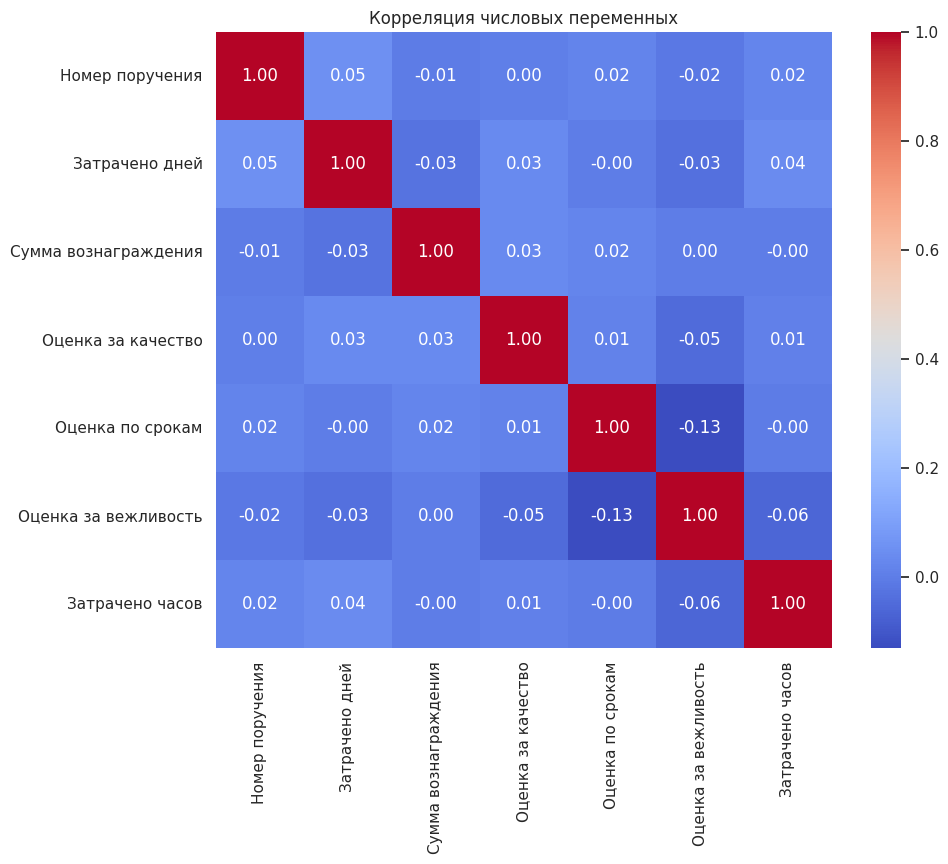

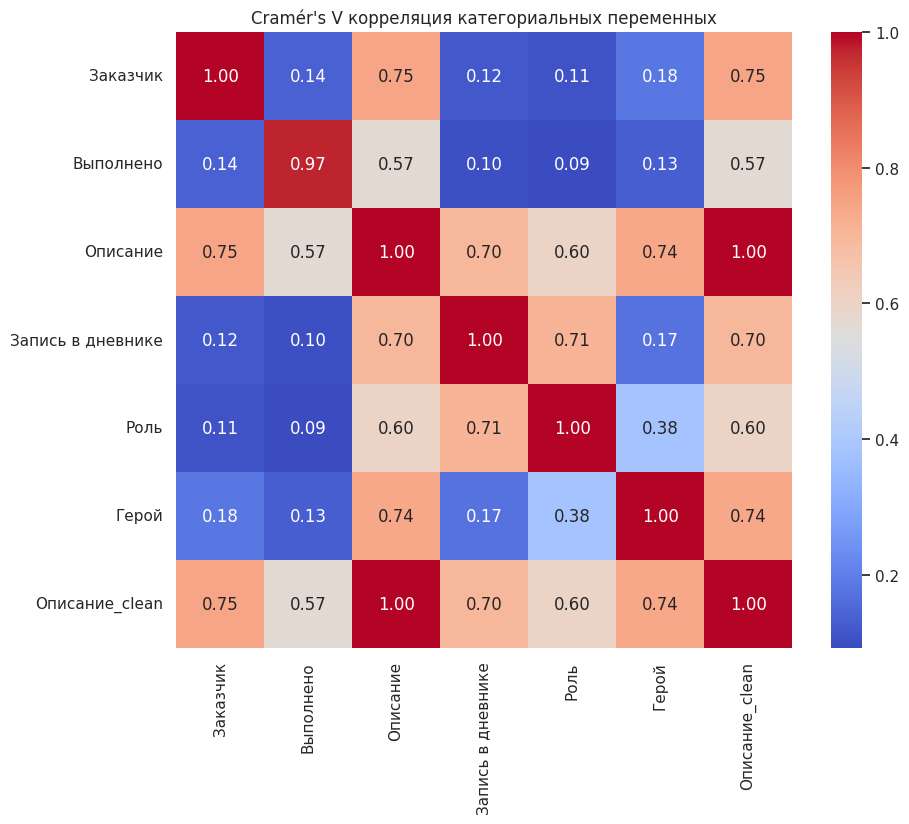

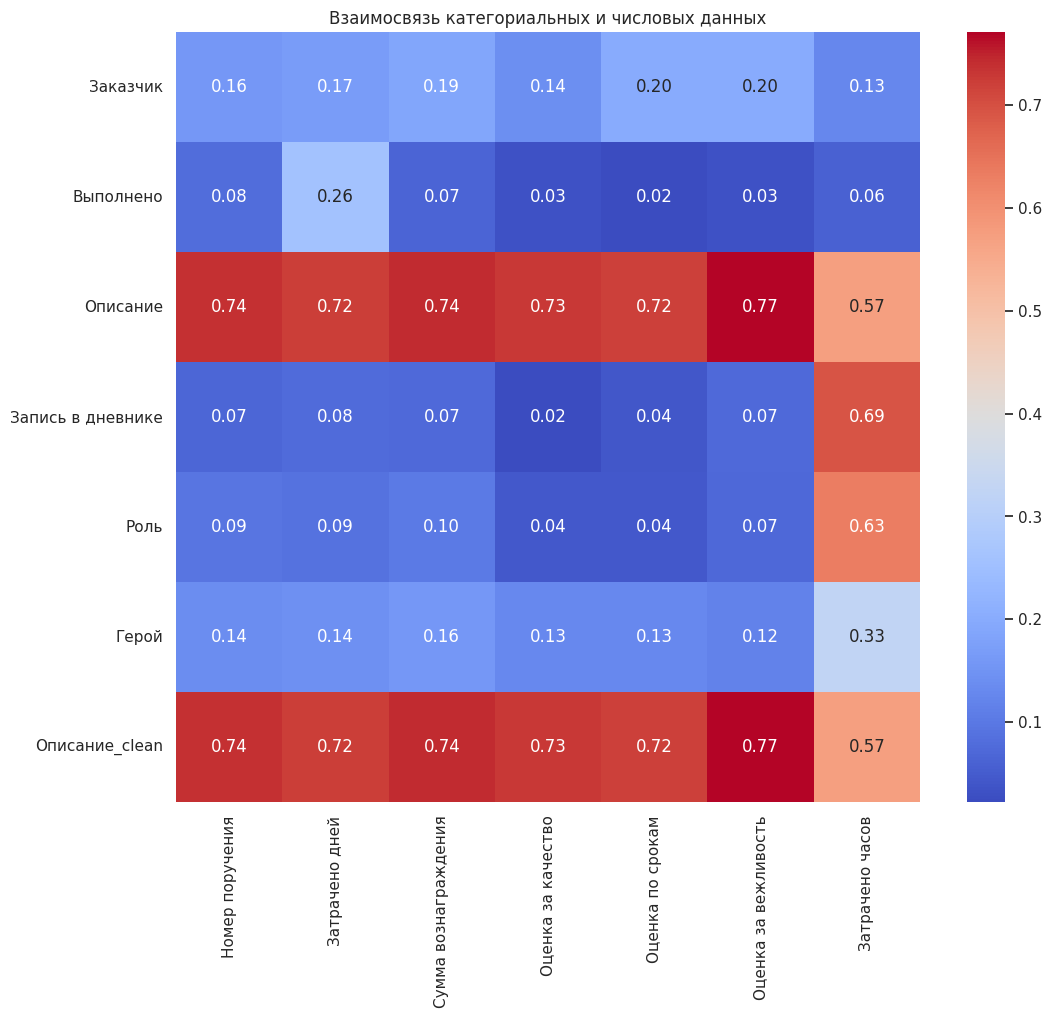

In [ ]:
# фильтрация числовых и категориальных данных с простыми типами
numerical_cols = [col for col in merged_data.select_dtypes(include=np.number).columns if merged_data[col].apply(lambda x: isinstance(x, (int, float, np.number))).all()]
categorical_cols = [col for col in merged_data.select_dtypes(include='object').columns if merged_data[col].apply(lambda x: isinstance(x, str)).all()]

# корреляция числовых переменных (метод Спирмена)
corr_numeric = merged_data[numerical_cols].corr(method='spearman')

# функция для вычисления Cramér’s V для категориально-числовых и категориально-категориальных переменных
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# создание матрицы Cramér’s V
cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(merged_data[col1], merged_data[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

# график корреляции числовых данных
plt.figure(figsize=(10, 8))
sns.heatmap(corr_numeric, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Корреляция числовых переменных')
plt.show()

# график Cramér’s V для категориальных данных
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Cramér's V корреляция категориальных переменных")
plt.show()

# анализ связи категориальных и числовых данных
cat_num_corr = pd.DataFrame(index=categorical_cols, columns=numerical_cols)
for cat in categorical_cols:
    for num in numerical_cols:
        cat_num_corr.loc[cat, num] = cramers_v(merged_data[cat], pd.qcut(merged_data[num], q=4, duplicates='drop'))

cat_num_corr = cat_num_corr.astype(float)

# график корреляции категориальных и числовых данных
plt.figure(figsize=(12, 10))
sns.heatmap(cat_num_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Взаимосвязь категориальных и числовых данных")
plt.show()

Судя по графикам, числовые переменные между собой вообще не коррелируют. А вот у категориальных между собой и у категориальных с числовыми есть взаимосвязь.

'Описание' и 'Роль' (0.74), 'Описание' и 'Герой' (0.74), 'Описание' и 'Запись в дневнике' (0.70) — сильная корреляция указывает на то, что описание задачи сильно связано с ролью, которую выполняет герой, а также с действиями, записанными в дневнике.

'Запись в дневнике' и 'Рол' (1.0) — максимальное значение связи говорит о том, что определенные действия в дневнике строго связаны с конкретными ролями героев.


'Описание_clean' с другими переменными, такими как 'Заказчик' (0.75), 'Запись в дневнике' (1.0), 'Роль' (0.74) — очищенное описание также хорошо коррелирует с другими характеристиками задачи, что говорит о корректности обработки текстовых данных для анализа.

'Выполнено' с 'Описание' (0.57) — связь между выполнением задачи и её описанием, что может указывать на специфические характеристики задач, которые приводят к успешному выполнению.

'Описание' с числовыми показателями, такими как вознаграждение (0.74), оценкам за качество (0.73), по срокам (0.72), вежливость (0.77) — задачи с определенным типом описания часто имеют схожие числовые характеристики, такие как более высокие оценки, что указывает на важность текста описания для прогнозирования эффективности задач.

'Запись в дневник' и время выполнения ( 0.69) — действия героев, отраженные в дневниках, часто связаны с затраченным временем, что может быть полезно для оценки эффективности ролей в зависимости от их действий.

'Выполнено' с числовыми данными (например, оценка по срокам — 0.26) — слабая корреляция между выполнением задач и оценками по срокам говорит о том, что не все успешно выполненные задачи получили высокие оценки по срокам, возможно из-за других факторов, влияющих на выполнение задачи.

Визуализации данных показывают, что описание задачи и запись в дневнике оказывают существенное влияние на результаты выполнения и оценки, полученные героями. Установленные корреляции указывают на сильную связь между описанием задачи, ролью и действиями героев, что помогает лучше понимать вклад каждого героя в выполнение задачи и факторы, влияющие на успешность выполнения. Эти наблюдения могут быть полезны для разработки модели, которая будет учитывать текстовые и числовые данные для оптимального распределения задач между героями и формирования команд.

# Дневник героя

Для того чтобы подбирать самую эффективную команду надо сначала создать таблицу с навыками героев.

Создаю таблицу hero_success, в которой для каждого героя вычисляются следующие агрегированные метрики:
- средние значения для оценок по качеству, срокам и вежливости
- редняя скорость выполнения задачи (в днях)
- сумма вознаграждения (берется первое значение, так как предполагается, что оно одинаково для всех записей героя)
- количество уникальных выполненных задач

In [ ]:
# метрики успешности
hero_success = (
    merged_data.groupby('Герой')
    .agg({
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean',
        'Затрачено дней': 'mean',
        'Сумма вознаграждения': 'first',
        'Номер поручения': "nunique"
    })
    .rename(columns={
        'Оценка за качество': 'Средняя оценка за качество',
        'Оценка по срокам': 'Средняя оценка по срокам',
        'Оценка за вежливость': 'Средняя оценка за вежливость',
        'Затрачено дней': 'Средняя скорость выполнения (дней)',
        'Сумма вознаграждения': 'Сумма вознаграждения',
        'Номер поручения': 'Количество выполненных задач'
    })
    .reset_index()
)

hero_success.head()

,Герой,Средняя оценка за качество,Средняя оценка по срокам,Средняя оценка за вежливость,Средняя скорость выполнения (дней),Сумма вознаграждения,Количество выполненных задач
0,Агата,3.882353,3.647059,3.941176,30.627451,9000,33
1,Альфред,3.841463,3.731707,3.878049,33.390244,20000,39
2,Бендер,3.984615,3.938462,3.938462,27.969231,5500,42
3,Бенедикт,3.802469,3.876543,3.888889,36.333333,25500,42
4,Глюкоза,3.878788,3.893939,4.000000,30.893939,24000,44


Основная таблица создана, теперь добавлю новых метрик.

Сначала надо разделить колонку "Роль" на отдельные строки. Если у героя в одной записи указано несколько ролей, они разделяются на индивидуальные строки, чтобы можно было рассчитать метрики отдельно для каждой роли.

Потом для каждой комбинации "герой-роль" вычисляются среднее время выполнения (в днях) и средние оценки по качеству, срокам и вежливости. Далее столбцы переименовываются для улучшения читаемости и понимания данных.

В следующем шаге таблица avg_metrics_by_role преобразуется так, чтобы для каждой роли создавались отдельные столбцы. Например, для роли "лекарь" будут созданы столбцы 'Среднее время выполнения_Лекарь', 'Средняя оценка за качество_Лекарь' и так далее. Это упрощает анализ метрик героев по каждой роли.

На последнем этапе таблицы hero_success и avg_metrics_by_role_pivot объединяются по столбцу 'Герой', чтобы собрать полные данные о метриках успешности героев в одной таблице hero_success_full. Эта таблица будет содержать как общие показатели успешности для каждого героя, так и показатели, разбитые по ролям.

In [ ]:
# показатели по ролям
roles_data = (
    merged_data
    .assign(Роль=merged_data['Роль'].str.split(', '))
    .explode('Роль')
)

avg_metrics_by_role = (
    roles_data.groupby(['Герой', 'Роль'])
    .agg({
        'Затрачено дней': 'mean',
        'Оценка за качество': 'mean',
        'Оценка по срокам': 'mean',
        'Оценка за вежливость': 'mean'
    })
    .reset_index()
)

avg_metrics_by_role = avg_metrics_by_role.rename(columns={
    'Затрачено дней': 'Среднее время выполнения',
    'Оценка за качество': 'Средняя оценка за качество',
    'Оценка по срокам': 'Средняя оценка по срокам',
    'Оценка за вежливость': 'Средняя оценка за вежливость'
})

avg_metrics_by_role_pivot = avg_metrics_by_role.pivot(index='Герой', columns='Роль')

avg_metrics_by_role_pivot.columns = ['_'.join(col).strip() for col in avg_metrics_by_role_pivot.columns.values]

hero_success_full = hero_success.merge(avg_metrics_by_role_pivot, on='Герой', how='left')

hero_success_full.head()

,Герой,Средняя оценка за качество,Средняя оценка по срокам,Средняя оценка за вежливость,Средняя скорость выполнения (дней),Сумма вознаграждения,Количество выполненных задач,Среднее время выполнения_боевой маг,Среднее время выполнения_лекарь,Среднее время выполнения_лучник,...,Средняя оценка по срокам_лучник,Средняя оценка по срокам_мечник,Средняя оценка по срокам_рейнджер,Средняя оценка по срокам_следопыт,Средняя оценка за вежливость_боевой маг,Средняя оценка за вежливость_лекарь,Средняя оценка за вежливость_лучник,Средняя оценка за вежливость_мечник,Средняя оценка за вежливость_рейнджер,Средняя оценка за вежливость_следопыт
0,Агата,3.882353,3.647059,3.941176,30.627451,9000,33,NaN,NaN,24.470588,...,3.705882,NaN,3.000000,3.777778,NaN,NaN,4.176471,NaN,4.000000,3.777778
1,Альфред,3.841463,3.731707,3.878049,33.390244,20000,39,NaN,34.00,NaN,...,NaN,3.730769,3.923077,3.571429,NaN,3.636364,NaN,3.769231,4.076923,4.142857
2,Бендер,3.984615,3.938462,3.938462,27.969231,5500,42,NaN,NaN,NaN,...,NaN,3.863636,4.000000,3.972973,NaN,NaN,NaN,4.045455,4.500000,3.783784
3,Бенедикт,3.802469,3.876543,3.888889,36.333333,25500,42,NaN,38.25,NaN,...,NaN,4.000000,3.909091,3.677419,NaN,4.062500,NaN,3.956522,3.818182,3.774194
4,Глюкоза,3.878788,3.893939,4.000000,30.893939,24000,44,25.6,NaN,NaN,...,NaN,NaN,3.444444,4.156250,4.08,NaN,NaN,NaN,4.333333,3.843750


В новой таблице получилось много пропусков, это связано с тем, что герой невыполнял задачи в данной роли, поэтому оценок нет. Считаю нужным заполнить пропуски нулями, так они не будут мешать дальнейшей работе с данными. А еще чтобы числа были более читаемыми, я округлила их до двух знаков.

In [ ]:
# Заполняем пропуски нулями
hero_success_full = hero_success_full.fillna(0).round(2)

hero_success_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Герой                                    12 non-null     object 
 1   Средняя оценка за качество               12 non-null     float64
 2   Средняя оценка по срокам                 12 non-null     float64
 3   Средняя оценка за вежливость             12 non-null     float64
 4   Средняя скорость выполнения (дней)       12 non-null     float64
 5   Сумма вознаграждения                     12 non-null     int64  
 6   Количество выполненных задач             12 non-null     int64  
 7   Среднее время выполнения_боевой маг      12 non-null     float64
 8   Среднее время выполнения_лекарь          12 non-null     float64
 9   Среднее время выполнения_лучник          12 non-null     float64
 10  Среднее время выполнения_мечник          12 non-null

А теперь можно посмотреть на метрики для каждого героя, разбитую по ролям. Для этого создаю список ролей, по которым нужно собрать метрики. Создаю словарь role_analysis, который будет содержать данные для каждой роли. Ключом в словаре будет роль, а значением — датафрейм с метриками для героев, играющих эту роль.

Начинается цикл по каждой роли из списка roles. Для каждой роли создается словарь role_metrics, который будет содержать информацию о герое и его средние метрики в этой роли. Затем код проходит по каждому герою в таблице hero_success_full и проверяет значения метрик по каждой роли. Внутри этого цикла извлекаются значения метрик для текущего героя и выбранной роли.

Затем создаются quality, time, politeness, и speed, которые содержат значения средней оценки за качество, по срокам, за вежливость и средней скорости выполнения (в днях) для текущего героя и текущей роли.

Метрики добавляются в role_metrics только если все значения больше 0. Это позволяет исключить случаи, когда данные для этой роли у героя отсутствуют.
Если условие выполняется, данные добавляются в role_metrics. Потом данные для текущей роли сохраняются как датафрейм в словаре role_analysis под соответствующим ключом роли. В конце идет итерация по всем ролям в role_analysis, чтобы напечатать датафрейм с метриками для каждого героя в каждой роли.





In [ ]:
# метрики для каждого героя
roles = ['боевой маг', 'лекарь', 'лучник', 'мечник', 'рейнджер', 'следопыт']

role_analysis = {}

for role in roles:
    role_metrics = {
        'Герой': [],
        'Средняя оценка за качество': [],
        'Средняя оценка по срокам': [],
        'Средняя оценка за вежливость': [],
        'Средняя скорость выполнения (дней)': []
    }

    for hero in hero_success_full['Герой']:
        quality = hero_success_full.loc[hero_success_full['Герой'] == hero, f'Средняя оценка за качество_{role}'].values[0]
        time = hero_success_full.loc[hero_success_full['Герой'] == hero, f'Средняя оценка по срокам_{role}'].values[0]
        politeness = hero_success_full.loc[hero_success_full['Герой'] == hero, f'Средняя оценка за вежливость_{role}'].values[0]
        speed = hero_success_full.loc[hero_success_full['Герой'] == hero, f'Среднее время выполнения_{role}'].values[0]

        if quality > 0 and time > 0 and politeness > 0 and speed > 0:
            role_metrics['Герой'].append(hero)
            role_metrics['Средняя оценка за качество'].append(quality)
            role_metrics['Средняя оценка по срокам'].append(time)
            role_metrics['Средняя оценка за вежливость'].append(politeness)
            role_metrics['Средняя скорость выполнения (дней)'].append(speed)

    role_analysis[role] = pd.DataFrame(role_metrics)

for role, df in role_analysis.items():
    print(f"Результаты для роли: {role}")
    print(df)
    print("\n")

Результаты для роли: боевой маг
     Герой  Средняя оценка за качество  Средняя оценка по срокам  \
0  Глюкоза                        3.76                      3.72   
1     Соня                        3.84                      4.00   

   Средняя оценка за вежливость  Средняя скорость выполнения (дней)  
0                          4.08                               25.60  
1                          4.00                               24.89  


Результаты для роли: лекарь
        Герой  Средняя оценка за качество  Средняя оценка по срокам  \
0     Альфред                        3.95                      3.77   
1    Бенедикт                        3.94                      4.06   
2      Мартин                        4.38                      3.88   
3  Синеглазый                        3.67                      3.83   
4        Соня                        3.73                      4.07   
5    Фредерик                        3.84                      4.11   
6        Юлия             

1. **Боевой маг**
Высокие показатели у Глюкозы и Сони по всем меткам, особенно по вежливости и скорости выполнения.
Остальные герои либо не имеют данных, либо имеют нулевые значения.
2. **Лекарь**
Мартин, Юлия, Фредерик и Альфред показывают хорошие результаты по всем меткам, особенно по срокам выполнения и качеству.
Глюкоза и другие герои имеют нулевые или отсутствующие данные.
3. **Лучник**
Агата и Мартин хорошо оцениваются по качеству и вежливости, но Мартин имеет высокие показатели по срокам.
Фредерик также выделяется по срокам, но остальные герои либо не имеют значений, либо имеют низкие результаты.
4. **Мечник**
Альфред, Бендер, Бенедикт и Пастушок имеют хорошие показатели по качеству, срокам и вежливости.
Некоторые герои, такие как Глюкоза, Мартин, Соня и другие, имеют нулевые значения.
5. **Рейнджер**
Бендер, Глюкоза и Пастушок имеют высокие оценки по качеству, срокам и вежливости, с относительно быстрым временем выполнения задач.
Фредерик и Соня показывают хорошие результаты, но некоторые герои, такие как Альфред, имеют слабые результаты.
6. **Следопыт**
Соня, Пастушок, Юлия и Фредерик выделяются по высоким оценкам качества и сроков.
Глюкоза, Мартин и другие показывают хорошие результаты по вежливости и срокам.

Команды могут быть более эффективными, если комбинировать героев с разными сильными сторонами, например, для задачи, требующей высокой скорости, можно выбрать героев с высокими оценками по срокам, а для более комплексных и требующих внимательности задач — тех, кто имеет высокую оценку за качество работы.
В общем, на основе этих данных можно рекомендовать героев для команд с учётом их сильных сторон и потребностей задачи, максимизируя эффективность и балансируя команды по ключевым меткам, таким как качество работы, скорость выполнения и вежливость.

# Аркаша

Для подбора героев, выполнявших аналогичные задачи создаю матрицу сходства. Для каждого очищенного описания поручения ('Описание_clean') рассчитывается эмбеддинг с помощью предобученной модели (model). Эмбеддинг — это числовое представление текста в векторном пространстве, которое позволяет анализировать семантическую близость текстов.

Далее преобразую результат в тензор PyTorch, который может быть использован для расчетов. Создается один тензор, объединяющий все эмбеддинги описаний задач из таблицы merged_data. torch.stack упаковывает эмбеддинги в многомерный тензор, где каждый элемент соответствует эмбеддингу одного описания. Пороговое значение (0.90) определяет, какие задачи будут считаться схожими. Если значение косинусного сходства между двумя задачами выше этого порога, задачи считаются достаточно похожими.

In [ ]:
# создание эмбеддинга
merged_data['Описание_embedding'] = merged_data['Описание_clean'].apply(lambda x: model.encode(x, convert_to_tensor=True))

embeddings_tensor = torch.stack(list(merged_data['Описание_embedding']))

similarity_matrix = util.pytorch_cos_sim(embeddings_tensor, embeddings_tensor)

threshold = 0.90

merged_data.head()

,Номер поручения,Заказчик,Дата поручения,Выполнено,Дата выполнения,Затрачено дней,Сумма вознаграждения,Описание,Оценка за качество,Оценка по срокам,Оценка за вежливость,Запись в дневнике,Затрачено часов,Роль,Герой,Описание_clean,Описание_embedding
0,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,4,3,4,разжечь костёр,1.0,рейнджер,Мартин,в лесу по дороге от пещеры звери нападают на л...,"[tensor(-0.0593), tensor(0.0621), tensor(-0.05..."
1,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,4,3,4,выследить цель,6.0,следопыт,Мартин,в лесу по дороге от пещеры звери нападают на л...,"[tensor(-0.0593), tensor(0.0621), tensor(-0.05..."
2,11000,Анна,1051-08-11 00:00:00,да,1051-08-21 00:00:00,10,6000,В лесу по дороге от пещеры звери нападают на л...,4,3,4,разжечь костёр,1.0,лучник,Мартин,в лесу по дороге от пещеры звери нападают на л...,"[tensor(-0.0593), tensor(0.0621), tensor(-0.05..."
3,11001,Мария,1051-07-09 00:00:00,да,1051-09-02 00:00:00,55,20000,В лесу по дороге от пещеры были замечены разбо...,5,5,4,разжечь костёр,1.0,рейнджер,Альфред,в лесу по дороге от пещеры были замечены разбо...,"[tensor(-0.0205), tensor(0.0913), tensor(-0.05..."
4,11001,Мария,1051-07-09 00:00:00,да,1051-09-02 00:00:00,55,20000,В лесу по дороге от пещеры были замечены разбо...,5,5,4,залечить раны,18.0,лекарь,Альфред,в лесу по дороге от пещеры были замечены разбо...,"[tensor(-0.0205), tensor(0.0913), tensor(-0.05..."


Теперь все готово для создания Аркаши. По сути Аркаша - это рекомендательная система, функция, которая на основе описания нового задания подбирает команду героев с учетом опыта, эффективности и финансовой выгоды.

Функция принимает на вход описание нового задания и создает его эмбеддинг, чтобы затем сравнить с эмбеддингами уже выполненных задач. Сравниваются эмбеддинги нового задания с эмбеддингами описаний задач из merged_data, и вычисляется косинусное сходство между ними. Полученные значения записываются в столбец similarity таблицы merged_data.

Из merged_data отбираются задачи, схожие с новым заданием (выше заданного порога similarity_threshold, по умолчанию 0.90). Эти задачи сортируются по убыванию схожести, чтобы сначала рассматривать наиболее похожие. Затем вычисляются наиболее часто встречающиеся комбинации "роль-действие" в отобранных похожих задачах. Таким образом, формируется список необходимых ролей и действий для команды (максимум 4 роли).

Для каждой роли и действия отбираются задачи из similar_tasks, фильтруется по соответствующей роли и действию, а затем сортируется по вознаграждению (по убыванию) и затраченному времени (по возрастанию). Это помогает выбрать самого прибыльного и быстрого героя для каждой роли.

Из отобранных задач выбирается герой для каждого уникального сочетания роли и действия, с учетом того, что герой и действие не должны повторяться в команде. Уникальные герои и действия добавляются в наборы unique_heroes и unique_actions соответственно, а вознаграждение героя добавляется к total_profit. Информация о роли, герое, вознаграждении, средней оценке качества, сроках, вежливости и времени выполнения выводится для каждого выбранного героя.

В конце функция возвращает сформированную команду героев с их ролями и общую сумму вознаграждения.

In [ ]:
#АРКАША
def recommend_team(new_task_description, merged_data, hero_success_full, similarity_threshold=0.90):

    new_task_embedding = model.encode([new_task_description])[0]

    task_embeddings = list(merged_data['Описание_embedding'])
    similarities = cosine_similarity([new_task_embedding], task_embeddings)[0]
    merged_data['similarity'] = similarities

    similar_tasks = merged_data[merged_data['similarity'] >= similarity_threshold]
    similar_tasks = similar_tasks.sort_values(by='similarity', ascending=False)

    role_action_counts = similar_tasks.groupby(['Роль', 'Запись в дневнике']).size().sort_values(ascending=False)
    required_roles_actions = role_action_counts.index.tolist()[:4]

    recommended_team = []
    unique_heroes = set()
    unique_actions = set()
    total_profit = 0

    print(f"Подбор команды для задания: '{new_task_description}'")
    print("------------------------------------------------------------")

    for (role, action) in required_roles_actions:
        role_tasks = similar_tasks[(similar_tasks['Роль'] == role) & (similar_tasks['Запись в дневнике'] == action)]
        role_tasks = role_tasks.sort_values(by=["Сумма вознаграждения", "Затрачено часов"], ascending=[False, True])


        for _, task in role_tasks.iterrows():
            hero = task['Герой']
            reward = task['Сумма вознаграждения']
            task_time_hours = task['Затрачено часов']
            diary_entry = task['Запись в дневнике']

            hero_stats = hero_success_full[hero_success_full['Герой'] == hero]
            avg_quality = hero_stats[f'Средняя оценка за качество_{role}'].values[0]
            avg_politeness = hero_stats[f'Средняя оценка за вежливость_{role}'].values[0]
            avg_deadline = hero_stats[f'Средняя оценка по срокам_{role}'].values[0]

            if hero not in unique_heroes and action not in unique_actions:
                recommended_team.append((hero, role))
                unique_heroes.add(hero)
                unique_actions.add(action)
                total_profit += reward

                print(f"Роль: {role}, Герой: {hero}")
                print(f"  Вознаграждение: {reward}")
                print(f"  Средняя оценка за качество: {avg_quality}")
                print(f"  Средняя оценка по срокам: {avg_deadline}")
                print(f"  Средняя оценка за вежливость: {avg_politeness}")
                print(f"  Затраченное время на выполнение (часы): {task_time_hours}")
                print(f"  Запись в дневнике (действие): {diary_entry}")
                print("------------------------------------------------------------")
                break

    print(f"Общая сумма вознаграждения для команды: {total_profit}\n")
    return recommended_team, total_profit

Этими фразами можно проверитьАркашу на работоспособность:

- В лесу по дороге от пещеры звери нападают на людей. Нужно убить их. Осмотрите все возможные укрытия, чтобы найти зверей.

- В пещере появвилось огромное каменное чудовище. Нужно уничтожить его.

- В лесу около деревни разбойники нападают на людей. Нужно проучить их.

- Недалеко от города монстры похитили путников. Нужно спасти их. Осмотрите все возможные укрытия, чтобы найти похищенных.

In [ ]:
# тут надо вводить новые задания и Аркаша подберет героев
new_task_description_1 = "В городе у меня пропала сумка с документами. Нужно найти её как можно скорее."
team_1, total_profit = recommend_team(new_task_description_1, merged_data, hero_success_full)

new_task_description_2 = "В пещере появилось огромное каменное чудовище. Нужно убить его."
team_2, total_profit = recommend_team(new_task_description_2, merged_data, hero_success_full)

Подбор команды для задания: 'В городе у меня пропала сумка с документами. Нужно найти её как можно скорее.'
------------------------------------------------------------
Роль: следопыт, Герой: Пастушок
  Вознаграждение: 26500
  Средняя оценка за качество: 4.15
  Средняя оценка по срокам: 3.73
  Средняя оценка за вежливость: 4.02
  Затраченное время на выполнение (часы): 9.0
  Запись в дневнике (действие): найти пропажу
------------------------------------------------------------
Роль: следопыт, Герой: Бендер
  Вознаграждение: 26000
  Средняя оценка за качество: 3.92
  Средняя оценка по срокам: 3.97
  Средняя оценка за вежливость: 3.78
  Затраченное время на выполнение (часы): 6.0
  Запись в дневнике (действие): отыскать заказчика
------------------------------------------------------------
Общая сумма вознаграждения для команды: 52500

Подбор команды для задания: 'В пещере появилось огромное каменное чудовище. Нужно убить его.'
-----------------------------------------------------------

Сначала меня смутил тот факт, что Аркаша для одного задания подобрал двух героев с одинаковой ролью. Но он все сделал верно, такие задания предполагают использования роли следопыта для поиска пропажи и поиска заказчика, так что Аркаша работает очень хорошо.

# Рандомная команда

Для более честной проверки работоспособности Аркаши, я взяла не просто рандомный набор команд. Я собрала команды, которые подбираются аналогично ему, то есть используя максимальную схожесть с описанием подбирается самая подходящая роль. Единственное отличие - не используется сортировка для поиска самых оплачиваемых и самых быстрых.

После сравнения выяснилось, что действительно сортировка по максимальной сумме и минимальному времени выполнения задания работают гораздо лучше, чем если подбирать команды сортировку не исользуя.





In [ ]:
# рандомная команда без сортировки
def recommend_team_random(new_task_description, merged_data, hero_success_full, similarity_threshold=0.90):

    new_task_embedding = model.encode([new_task_description])[0]

    task_embeddings = list(merged_data['Описание_embedding'])
    similarities = cosine_similarity([new_task_embedding], task_embeddings)[0]
    merged_data['similarity'] = similarities

    similar_tasks = merged_data[merged_data['similarity'] >= similarity_threshold]
    similar_tasks = similar_tasks.sort_values(by='similarity', ascending=False)

    role_action_counts = similar_tasks.groupby(['Роль', 'Запись в дневнике']).size().sort_values(ascending=False)
    required_roles_actions = role_action_counts.index.tolist()[:4]

    recommended_team = []
    unique_heroes = set()
    unique_actions = set()
    total_profit = 0

    print(f"Подбор команды для задания: '{new_task_description}'")
    print("------------------------------------------------------------")

    for (role, action) in required_roles_actions:

        role_tasks = similar_tasks[(similar_tasks['Роль'] == role) & (similar_tasks['Запись в дневнике'] == action)]

        for _, task in role_tasks.iterrows():
            hero = task['Герой']
            reward = task['Сумма вознаграждения']
            task_time_hours = task['Затрачено часов']
            diary_entry = task['Запись в дневнике']

            hero_stats = hero_success_full[hero_success_full['Герой'] == hero]
            avg_quality = hero_stats[f'Средняя оценка за качество_{role}'].values[0]
            avg_politeness = hero_stats[f'Средняя оценка за вежливость_{role}'].values[0]
            avg_deadline = hero_stats[f'Средняя оценка по срокам_{role}'].values[0]

            if hero not in unique_heroes and action not in unique_actions:
                recommended_team.append((hero, role))
                unique_heroes.add(hero)
                unique_actions.add(action)
                total_profit += reward

                print(f"Роль: {role}, Герой: {hero}")
                print(f"  Вознаграждение: {reward}")
                print(f"  Средняя оценка за качество: {avg_quality}")
                print(f"  Средняя оценка по срокам: {avg_deadline}")
                print(f"  Средняя оценка за вежливость: {avg_politeness}")
                print(f"  Затраченное время на выполнение (часы): {task_time_hours}")
                print(f"  Запись в дневнике (действие): {diary_entry}")
                print("------------------------------------------------------------")
                break

    print(f"Общая сумма вознаграждения для команды: {total_profit}\n")
    return recommended_team, total_profit

new_task_description_1 = "В городе у меня пропала сумка с документами. Нужно найти её как можно скорее."
team_1, total_profit_1 = recommend_team_random(new_task_description_1, merged_data, hero_success_full)

new_task_description_2 = "В пещере появилось огромное каменное чудовище. Нужно убить его."
team_2, total_profit_2 = recommend_team_random(new_task_description_2, merged_data, hero_success_full)

Подбор команды для задания: 'В городе у меня пропала сумка с документами. Нужно найти её как можно скорее.'
------------------------------------------------------------
Роль: следопыт, Герой: Соня
  Вознаграждение: 7500
  Средняя оценка за качество: 4.17
  Средняя оценка по срокам: 4.03
  Средняя оценка за вежливость: 3.66
  Затраченное время на выполнение (часы): 4.5
  Запись в дневнике (действие): найти пропажу
------------------------------------------------------------
Роль: следопыт, Герой: Юлия
  Вознаграждение: 22000
  Средняя оценка за качество: 3.85
  Средняя оценка по срокам: 3.77
  Средняя оценка за вежливость: 3.85
  Затраченное время на выполнение (часы): 3.0
  Запись в дневнике (действие): отыскать заказчика
------------------------------------------------------------
Общая сумма вознаграждения для команды: 29500

Подбор команды для задания: 'В пещере появилось огромное каменное чудовище. Нужно убить его.'
------------------------------------------------------------
Роль:

# Альтернативная версия: merged_data['Выполнено'] == 'нет'

Для более точной проверки, Аркаша попробует подобрать команды для невыполненных поручений. Для сравнения будет подбираться два варианта команд : в первом варианте будет происходить фильтрация по максимальной сумме и минимальному времени, во втором варианте фильтрации нет.

Для начала строки из таблицы merged_data фильтруются по условию, что в столбце "Выполнено" указано "нет". Это позволяет получить только те задачи, которые еще не были выполнены, и для которых нужно подобрать команду. Далее извлекается описание задачи (new_task_description) для дальнейшей работы.

Потом вызывается функция recommend_team, которая подбирает команду героев для выполнения задачи с учетом сортировки по критериям (по оплате и времени). Функция возвращает - recommended_team (список героев, выбранных для задачи, с их ролями) и total_profit_sorted (общая сумма вознаграждения для выбранной команды).

Затем вызывается функция recommend_team_random, которая выбирает команду без сортировки. Функция возвращает recommended_team_random (команда героев без сортировки) и total_profit_random (общая сумма вознаграждения для этой команды).

Далее команды героев с сортировкой и без сортировки преобразуются в строковый формат, где каждый герой представлен с его ролью. Это делается для удобства представления данных в итоговом датафрейме.

Для каждой из команд (с сортировкой и без) рассчитывается общее время выполнения задач, которое зависит от времени, затраченного каждым героем. Время берется из столбца "Затрачено часов" таблицы merged_data, где для каждого героя и его роли в таблице указано, сколько времени он потратил на выполнение задач.
Для команды с сортировкой (recommended_team), суммарное время (total_time_sorted) рассчитывается как сумма времени выполнения всех героев в команде.
Для команды без сортировки (recommended_team_random), аналогично рассчитывается суммарное время (total_time_random).

Для каждой задачи собираются данные о рекомендованных командах (с сортировкой и без сортировки), их общей сумме вознаграждений и суммарном времени выполнения. Все эти данные собираются в словарь team_data.

Все словари с данными о командах для каждой задачи сохраняются в список all_recommended_teams.
После завершения цикла, список преобразуется в датафрейм result_df, который содержит всю информацию о рекомендованных командах и их характеристиках для каждой невыполненной задачи.

In [ ]:
# подбор команд для невыполненных поручений
def recommend_team_combined(merged_data, hero_success_full, similarity_threshold=0.90):

    merged_data_incomplete = merged_data[merged_data['Выполнено'] == 'нет']

    all_recommended_teams = []

    for _, task in merged_data_incomplete.iterrows():
        new_task_description = task['Описание']

        recommended_team, total_profit_sorted = recommend_team(
            new_task_description, merged_data, hero_success_full, similarity_threshold
        )

        recommended_team_random, total_profit_random = recommend_team_random(
            new_task_description, merged_data, hero_success_full, similarity_threshold
        )

        recommended_team_str = "; ".join(
            [f"{member[1]} - {member[0]}" for member in recommended_team]
        )
        recommended_team_random_str = "; ".join(
            [f"{member[1]} - {member[0]}" for member in recommended_team_random]
        )

        total_time_sorted = sum([
            merged_data[(merged_data['Герой'] == hero) & (merged_data['Роль'] == role)]['Затрачено часов'].values[0]
            for hero, role in recommended_team
        ])

        total_time_random = sum([
            merged_data[(merged_data['Герой'] == hero) & (merged_data['Роль'] == role)]['Затрачено часов'].values[0]
            for hero, role in recommended_team_random
        ])

        team_data = {
            'Номер поручения': task['Номер поручения'],
            'Задача': new_task_description,
            'Рекомендованная команда с сортировкой': recommended_team_str,
            'Общая сумма с сортировкой': total_profit_sorted,
            'Суммарное время с сортировкой (часы)': total_time_sorted,
            'Рекомендованная команда без сортировки': recommended_team_random_str,
            'Общая сумма без сортировки': total_profit_random,
            'Суммарное время без сортировки (часы)': total_time_random
        }
        all_recommended_teams.append(team_data)

    result_df = pd.DataFrame(all_recommended_teams)
    return result_df

result_df = recommend_team_combined(merged_data, hero_success_full, similarity_threshold=0.90)

Подбор команды для задания: 'По дороге из деревни у меня пропала драгоценность. Нужно вернуть её как можно скорее.'
------------------------------------------------------------
Роль: следопыт, Герой: Бенедикт
  Вознаграждение: 29000
  Средняя оценка за качество: 3.71
  Средняя оценка по срокам: 3.68
  Средняя оценка за вежливость: 3.77
  Затраченное время на выполнение (часы): 3.0
  Запись в дневнике (действие): отыскать заказчика
------------------------------------------------------------
Роль: следопыт, Герой: Синеглазый
  Вознаграждение: 29000
  Средняя оценка за качество: 4.0
  Средняя оценка по срокам: 3.71
  Средняя оценка за вежливость: 3.9
  Затраченное время на выполнение (часы): 4.5
  Запись в дневнике (действие): найти пропажу
------------------------------------------------------------
Общая сумма вознаграждения для команды: 58000

Подбор команды для задания: 'По дороге из деревни у меня пропала драгоценность. Нужно вернуть её как можно скорее.'
---------------------------

In [ ]:
result_df

,Номер поручения,Задача,Рекомендованная команда с сортировкой,Общая сумма с сортировкой,Суммарное время с сортировкой (часы),Рекомендованная команда без сортировки,Общая сумма без сортировки,Суммарное время без сортировки (часы)
0,11056,По дороге из деревни у меня пропала драгоценно...,следопыт - Бенедикт; следопыт - Синеглазый,58000,10.5,следопыт - Синеглазый; следопыт - Пастушок,49500,15.0
1,11134,В пещере появвилось огромное каменное чудовище...,мечник - Пастушок; лекарь - Соня,56500,9.7,мечник - Бенедикт; лекарь - Фредерик,27500,20.0
2,11143,В пещере завёлся дракон. Нужно его убить. Это ...,лекарь - Мартин; мечник - Леопольд,56000,19.0,лекарь - Синеглазый; мечник - Пастушок,30000,18.7
3,11161,В городе у меня потерялся рюкзак. Нужно найти ...,следопыт - Юлия; следопыт - Леопольд,55500,10.5,следопыт - Агата; следопыт - Синеглазый,13000,10.0
4,11218,Недалеко от города монстры похитили путников. ...,следопыт - Юлия,28000,4.5,следопыт - Пастушок,17000,9.0
5,11232,В деревне монстры похитили путников. Нужно спа...,следопыт - Юлия,29000,4.5,следопыт - Пастушок,8000,9.0
6,11234,В лесу по дороге от пещеры заметили разбойнико...,рейнджер - Фредерик; лекарь - Соня,51500,10.0,рейнджер - Пастушок; лекарь - Соня,42500,10.0
7,11285,В городе у меня потерялся рюкзак. Нужно найти ...,следопыт - Юлия; следопыт - Леопольд,55500,10.5,следопыт - Агата; следопыт - Синеглазый,13000,10.0
8,11306,В деревне монстры похитили путников. Нужно спа...,следопыт - Юлия,29000,4.5,следопыт - Синеглазый,25500,6.0
9,11310,По дороге из деревни монстры похитили путников...,следопыт - Бенедикт,28000,4.5,следопыт - Глюкоза,25000,4.5


Подбор команды с сортировкой приводит к более высоким суммам вознаграждения, но требует иногда команда затрачивает немного больше времени, по сравнению с командой без сортировки. Но у команд без сортировки сумма вознаграждения значительно ниже, и если в первую очередь стоит вопрос о выручке для гильдии, то можно закрыть глаза на то, что небольшая часть поручений выполняется немного дольше.

В целом рекомендательная система с сортировкой показала очень хорошие результаты и может быть рекомендована Гильдии Искателей Приключений для сокращения риска неудачных миссий и значительного увеличения выручки